# 2024 CITS4012 Project
Group 64

Sandra Nguyen (22511782), Nicodemus Ong (22607943)

NOTE: Due to constraints in the Colab environment, we are unable to provide the running logs for the optimization process, as these were executed in a separate instance of another Colab notebook session. However, the code for the optimization process has been included here for your review, allowing you to verify the optimal metrics. The relevant code is provided at the end of the file for reference, detailing our approach to testing and determining the optimal metrics.

# 1.Dataset Processing


In [ ]:
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load JSON files into DataFrames

# Load the training data from a JSON file into a DataFrame
train_df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Project/train.json', orient='split')

# Load the validation data from a JSON file into a DataFrame
val_df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Project/val.json', orient='split')

# Load the test data from a JSON file into a DataFrame
test_df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Project/test.json', orient='split')


In [ ]:
def clean_text(text):
    """
    Cleans the input text by removing all punctuation and converting it to lowercase.
    
    Parameters:
    text (str): The text to be cleaned.
    
    Returns:
    str: The cleaned text.
    """
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

def tokenize_text(df):
    """
    Tokenizes the 'sentence' column and cleans the 'aspect' column in the input DataFrame.
    
    Parameters:
    df (DataFrame): The DataFrame containing 'sentence' and 'aspect' columns.
    
    Returns:
    tuple: A tuple containing two lists:
        - tokenized_texts (list of list of str): Tokenized and cleaned sentences.
        - tokenized_aspects (list of str): Cleaned aspects.
    """
    tokenized_texts = [word_tokenize(clean_text(text)) for text in df['sentence']]
    tokenized_aspects = [clean_text(aspect) for aspect in df['aspect']]
    return tokenized_texts, tokenized_aspects


In [ ]:
# Tokenize text and aspects
train_sentence, train_aspects = tokenize_text(train_df)
val_sentence, val_aspects = tokenize_text(val_df)
test_sentence, test_aspects = tokenize_text(test_df)

In [ ]:
# Initialize vocabulary
vocab = {'UNK': 0}

def build_vocab(texts):
    """
    Builds a vocabulary from the given texts. Adds each unique token to the vocabulary.
    
    Parameters:
    texts (list of list of str): A list of tokenized texts, where each text is a list of tokens.
    
    Returns:
    None
    """
    idx = len(vocab)
    for text in texts:
        for token in text:
            if token not in vocab:
                vocab[token] = idx
                idx += 1


In [ ]:
# Build vocabulary using only training data
build_vocab(train_sentence + [word_tokenize(aspect) for aspect in train_aspects])

In [ ]:
# Function to convert tokens to tensors
def tokens_to_tensor(tokens_list, vocab):
    """
    Converts a list of token lists into a tensor, padding sequences to the same length.
    
    Parameters:
    tokens_list (list of list of str): A list of tokenized texts, where each text is a list of tokens.
    vocab (dict): A dictionary mapping tokens to their corresponding indices.
    
    Returns:
    Tensor: A tensor containing the padded sequences of token indices.
    """
    sequences = [[vocab.get(token, vocab['UNK']) for token in tokens] for tokens in tokens_list]
    sequence_tensors = pad_sequence([torch.tensor(sequence) for sequence in sequences], batch_first=True, padding_value=vocab['UNK'])
    return sequence_tensors


In [ ]:
# Convert tokenized text and aspects to tensors
train_sentence = tokens_to_tensor(train_sentence, vocab)
train_aspects = torch.tensor([vocab.get(aspect, vocab['UNK']) for aspect in train_aspects])
val_sentence = tokens_to_tensor(val_sentence, vocab)
val_aspects = torch.tensor([vocab.get(aspect, vocab['UNK']) for aspect in val_aspects])
test_sentence = tokens_to_tensor(test_sentence, vocab)
test_aspects = torch.tensor([vocab.get(aspect, vocab['UNK']) for aspect in test_aspects])


In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
train_labels = torch.tensor(label_encoder.fit_transform(train_df['polarity']), dtype=torch.long)
val_labels = torch.tensor(label_encoder.transform(val_df['polarity']), dtype=torch.long)
test_labels = torch.tensor(label_encoder.transform(test_df['polarity']), dtype=torch.long)


In [ ]:
# Check the mapping of polarity to integer values
polarity_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print(polarity_mapping)

{0: 'negative', 1: 'neutral', 2: 'positive'}


In [ ]:
# Create tensor datasets
train_dataset = TensorDataset(train_sentence, train_aspects, train_labels)
val_dataset = TensorDataset(val_sentence, val_aspects, val_labels)
test_dataset = TensorDataset(test_sentence, test_aspects, test_labels)

In [ ]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
class AspectAwareLSTMModel(nn.Module):
    """
    An Aspect-Aware LSTM model for text classification, which incorporates aspect embeddings
    along with sentence embeddings to predict the class of the input text.
    
    Parameters:
    - vocab_size (int): The size of the vocabulary.
    - aspect_vocab_size (int): The size of the aspect vocabulary.
    - embedding_dim (int): The dimensionality of the sentence embeddings.
    - aspect_embedding_dim (int): The dimensionality of the aspect embeddings.
    - lstm_units (int): The number of LSTM units.
    - num_classes (int): The number of output classes.
    - dropout_rate (float, optional): The dropout rate (default is 0.25).
    """
    
    def __init__(self, vocab_size, aspect_vocab_size, embedding_dim, aspect_embedding_dim, lstm_units, num_classes, dropout_rate=0.25):
        super(AspectAwareLSTMModel, self).__init__()
        self.sentence_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.aspect_embedding = nn.Embedding(aspect_vocab_size, aspect_embedding_dim)

        self.sentence_lstm = nn.LSTM(embedding_dim, lstm_units, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.intermediate_fc = nn.Linear(lstm_units * 2 + aspect_embedding_dim, lstm_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(lstm_units, num_classes)

    def forward(self, sentence, aspect):
        sentence_embeds = self.sentence_embedding(sentence)
        aspect_embeds = self.aspect_embedding(aspect.unsqueeze(1)).squeeze(1)

        sentence_lstm_out, _ = self.sentence_lstm(sentence_embeds)

        last_hidden_state = sentence_lstm_out[:, -1, :]
        combined_embeds = torch.cat((last_hidden_state, aspect_embeds), dim=1)

        intermediate_output = self.intermediate_fc(combined_embeds)

        out = self.fc(intermediate_output)
        out = torch.softmax(out, dim=1)
        return out

    # Hyperparameters and other settings for AspectAwareLSTMModel
hyperparameters_aware = {
    'vocab_size': len(vocab),
    'aspect_vocab_size': len(vocab),
    'embedding_dim': 200,
    'aspect_embedding_dim': 100,
    'lstm_units': 128,
    'num_classes': len(polarity_mapping),
    'dropout_rate': 0.5,
    'learning_rate': 0.001,
    'num_epochs': 100,
    'batch_size': 32
}

In [ ]:
# Create an instance of the AspectAwareLSTMModel
model_aware = AspectAwareLSTMModel(
    hyperparameters_aware['vocab_size'],
    hyperparameters_aware['aspect_vocab_size'],
    hyperparameters_aware['embedding_dim'],
    hyperparameters_aware['aspect_embedding_dim'],
    hyperparameters_aware['lstm_units'],
    hyperparameters_aware['num_classes'],
    hyperparameters_aware['dropout_rate']
)
criterion_aware = nn.CrossEntropyLoss()
optimizer_aware = optim.Adam(model_aware.parameters(), lr=hyperparameters_aware['learning_rate'])

# Move the model to the appropriate device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_aware.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


AspectAwareLSTMModel(
  (sentence_embedding): Embedding(6864, 200)
  (aspect_embedding): Embedding(6864, 100)
  (sentence_lstm): LSTM(200, 128, batch_first=True, dropout=0.5, bidirectional=True)
  (intermediate_fc): Linear(in_features=356, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
train_losses_1 = []
train_accuracies_1 = []
val_losses_1 = []
val_accuracies_1 = []

for epoch in range(hyperparameters_aware['num_epochs']):
    model_aware.train()
    total_loss = 0
    correct = 0
    total = 0

    for sentences, aspects, labels in train_loader:
        sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)

        optimizer_aware.zero_grad()

        outputs = model_aware(sentences, aspects)
        loss = criterion_aware(outputs, labels)
        loss.backward()
        optimizer_aware.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses_1.append(train_loss)
    train_accuracies_1.append(train_accuracy)

    model_aware.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sentences, aspects, labels in val_loader:
            sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)
            outputs = model_aware(sentences, aspects)
            loss = criterion_aware(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses_1.append(val_loss)
    val_accuracies_1.append(val_accuracy)

    print(f'Epoch {epoch+1}/{hyperparameters_aware["num_epochs"]}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1/100, Train Loss: 0.9609, Train Accuracy: 0.5877, Validation Loss: 0.9504, Validation Accuracy: 0.5991
Epoch 2/100, Train Loss: 0.9563, Train Accuracy: 0.5894, Validation Loss: 0.9479, Validation Accuracy: 0.5991
Epoch 3/100, Train Loss: 0.9571, Train Accuracy: 0.5884, Validation Loss: 0.9649, Validation Accuracy: 0.5991
Epoch 4/100, Train Loss: 0.9571, Train Accuracy: 0.5921, Validation Loss: 0.9481, Validation Accuracy: 0.5991
Epoch 5/100, Train Loss: 0.9550, Train Accuracy: 0.5915, Validation Loss: 0.9476, Validation Accuracy: 0.5991
Epoch 6/100, Train Loss: 0.9555, Train Accuracy: 0.5917, Validation Loss: 0.9445, Validation Accuracy: 0.5991
Epoch 7/100, Train Loss: 0.9541, Train Accuracy: 0.5918, Validation Loss: 0.9445, Validation Accuracy: 0.5991
Epoch 8/100, Train Loss: 0.9540, Train Accuracy: 0.5903, Validation Loss: 0.9457, Validation Accuracy: 0.5991
Epoch 9/100, Train Loss: 0.9548, Train Accuracy: 0.5920, Validation Loss: 0.9459, Validation Accuracy: 0.5991
Epoch 10/1

In [ ]:
class AspectMultiLSTMModel(nn.Module):
    """
    An Aspect-Multi LSTM model for text classification, incorporating multiple LSTM layers
    and aspect embeddings to predict the class of the input text.
    
    Parameters:
    - vocab_size (int): The size of the vocabulary.
    - aspect_vocab_size (int): The size of the aspect vocabulary.
    - embedding_dim (int): The dimensionality of the sentence embeddings.
    - aspect_embedding_dim (int): The dimensionality of the aspect embeddings.
    - lstm_units (int): The number of LSTM units.
    - num_classes (int): The number of output classes.
    - num_layers (int, optional): The number of LSTM layers (default is 3).
    - dropout_rate (float, optional): The dropout rate (default is 0.25).
    """
    def __init__(self, vocab_size, aspect_vocab_size, embedding_dim, aspect_embedding_dim, lstm_units, num_classes, num_layers=3, dropout_rate=0.25):
        super(AspectMultiLSTMModel, self).__init__()
        self.sentence_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.aspect_embedding = nn.Embedding(aspect_vocab_size, aspect_embedding_dim)

        self.sentence_lstm = nn.LSTM(embedding_dim, lstm_units, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=dropout_rate if num_layers > 1 else 0)

        self.aspect_fc = nn.Linear(aspect_embedding_dim, lstm_units)
        self.aspect_fc_activation = nn.ReLU()

        self.intermediate_fc = nn.Linear(lstm_units * 3, lstm_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(lstm_units, num_classes)

    def forward(self, sentence, aspect):
        sentence_embeds = self.sentence_embedding(sentence)
        aspect_embeds = self.aspect_embedding(aspect.unsqueeze(1)).squeeze(1)

        sentence_lstm_out, _ = self.sentence_lstm(sentence_embeds)

        last_hidden_state = sentence_lstm_out[:, -1, :]

        # Process the aspect embedding through the dense layer
        aspect_fc_out = self.aspect_fc(aspect_embeds)
        aspect_fc_out = self.aspect_fc_activation(aspect_fc_out)

        combined_embeds = torch.cat((last_hidden_state, aspect_fc_out), dim=1)

        intermediate_output = self.intermediate_fc(combined_embeds)
        intermediate_output = self.dropout(intermediate_output)

        out = self.fc(intermediate_output)
        out = torch.softmax(out, dim=1)
        return out

# Hyperparameters and other settings for AspectMultiLSTMModel
hyperparameters_multi = {
    'vocab_size': len(vocab),
    'aspect_vocab_size': len(vocab),
    'embedding_dim': 100,
    'aspect_embedding_dim': 50,
    'lstm_units': 128,
    'num_classes': len(polarity_mapping),
    'num_layers': 3,
    'dropout_rate': 0.25,
    'learning_rate': 1e-6,
    'num_epochs': 100,
    'batch_size': 32
}

In [ ]:
# Create an instance of the AspectMultiLSTMModel
model_multi = AspectMultiLSTMModel(
    hyperparameters_multi['vocab_size'],
    hyperparameters_multi['aspect_vocab_size'],
    hyperparameters_multi['embedding_dim'],
    hyperparameters_multi['aspect_embedding_dim'],
    hyperparameters_multi['lstm_units'],
    hyperparameters_multi['num_classes'],
    hyperparameters_multi['num_layers'],
    hyperparameters_multi['dropout_rate']
)

criterion_multi = nn.CrossEntropyLoss()
optimizer_multi = optim.Adam(model_multi.parameters(), lr=hyperparameters_multi['learning_rate'])

# Move the model to the appropriate device (e.g., GPU)
model_multi.to(device)

AspectMultiLSTMModel(
  (sentence_embedding): Embedding(6864, 100)
  (aspect_embedding): Embedding(6864, 50)
  (sentence_lstm): LSTM(100, 128, num_layers=3, batch_first=True, dropout=0.25, bidirectional=True)
  (aspect_fc): Linear(in_features=50, out_features=128, bias=True)
  (aspect_fc_activation): ReLU()
  (intermediate_fc): Linear(in_features=384, out_features=128, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
train_losses_2 = []
train_accuracies_2 = []
val_losses_2 = []
val_accuracies_2 = []

for epoch in range(hyperparameters_multi['num_epochs']):
    model_multi.train()
    total_loss = 0
    correct = 0
    total = 0

    for sentences, aspects, labels in train_loader:
        sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)

        optimizer_multi.zero_grad()

        outputs = model_multi(sentences, aspects)
        loss = criterion_multi(outputs, labels)
        loss.backward()
        optimizer_multi.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses_2.append(train_loss)
    train_accuracies_2.append(train_accuracy)

    model_multi.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sentences, aspects, labels in val_loader:
            sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)
            outputs = model_multi(sentences, aspects)
            loss = criterion_multi(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses_2.append(val_loss)
    val_accuracies_2.append(val_accuracy)

    print(f'Epoch {epoch+1}/{hyperparameters_multi["num_epochs"]}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1/100, Train Loss: 1.1035, Train Accuracy: 0.2786, Validation Loss: 1.1026, Validation Accuracy: 0.2928
Epoch 2/100, Train Loss: 1.1007, Train Accuracy: 0.2983, Validation Loss: 1.0997, Validation Accuracy: 0.2905
Epoch 3/100, Train Loss: 1.0980, Train Accuracy: 0.3398, Validation Loss: 1.0969, Validation Accuracy: 0.2905
Epoch 4/100, Train Loss: 1.0957, Train Accuracy: 0.3726, Validation Loss: 1.0940, Validation Accuracy: 0.4786
Epoch 5/100, Train Loss: 1.0925, Train Accuracy: 0.4357, Validation Loss: 1.0910, Validation Accuracy: 0.4730
Epoch 6/100, Train Loss: 1.0895, Train Accuracy: 0.4994, Validation Loss: 1.0879, Validation Accuracy: 0.5664
Epoch 7/100, Train Loss: 1.0865, Train Accuracy: 0.5275, Validation Loss: 1.0846, Validation Accuracy: 0.5664
Epoch 8/100, Train Loss: 1.0831, Train Accuracy: 0.5443, Validation Loss: 1.0812, Validation Accuracy: 0.5676
Epoch 9/100, Train Loss: 1.0801, Train Accuracy: 0.5375, Validation Loss: 1.0776, Validation Accuracy: 0.5586
Epoch 10/1

In [ ]:
class AspectAttentionLSTMModel(nn.Module):
    """
    An Aspect-Attention LSTM model for text classification, incorporating attention mechanisms
    along with aspect embeddings to predict the class of the input text.
    
    Parameters:
    - vocab_size (int): The size of the vocabulary.
    - aspect_vocab_size (int): The size of the aspect vocabulary.
    - embedding_dim (int): The dimensionality of the sentence embeddings.
    - aspect_embedding_dim (int): The dimensionality of the aspect embeddings.
    - lstm_units (int): The number of LSTM units.
    - num_classes (int): The number of output classes.
    - num_layers (int, optional): The number of LSTM layers (default is 3).
    - dropout_rate (float, optional): The dropout rate (default is 0.25).
    """
    def __init__(self, vocab_size, aspect_vocab_size, embedding_dim, aspect_embedding_dim, lstm_units, num_classes, num_layers=3, dropout_rate=0.25):
        super(AspectAttentionLSTMModel, self).__init__()
        self.sentence_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.aspect_embedding = nn.Embedding(aspect_vocab_size, aspect_embedding_dim)

        self.attention_fc_key = nn.Linear(embedding_dim, lstm_units)
        self.attention_fc_value = nn.Linear(embedding_dim, lstm_units)
        self.attention_fc_query = nn.Linear(aspect_embedding_dim, lstm_units)

        self.attention_softmax = nn.Softmax(dim=1)

        self.sentence_lstm = nn.LSTM(embedding_dim, lstm_units, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=dropout_rate if num_layers > 1 else 0)

        self.intermediate_fc = nn.Linear(lstm_units * 2 + lstm_units + aspect_embedding_dim, lstm_units)  # Adjust to match concatenated size (256 + 128 + 50)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(lstm_units, num_classes)

    def forward(self, sentence, aspect):
        # Sentence embedding
        sentence_embeds = self.sentence_embedding(sentence)

        # Aspect embedding
        aspect_embeds = self.aspect_embedding(aspect)

        # Attention mechanism
        key = self.attention_fc_key(sentence_embeds)
        value = self.attention_fc_value(sentence_embeds)
        query = self.attention_fc_query(aspect_embeds).unsqueeze(1)

        attention_weights = self.attention_softmax(torch.bmm(query, key.transpose(1, 2)).squeeze(1))
        context_vector = torch.sum(attention_weights.unsqueeze(2) * value, dim=1)

        # LSTM
        sentence_lstm_out, _ = self.sentence_lstm(sentence_embeds)

        # Concatenation
        combined_embeds = torch.cat((sentence_lstm_out[:, -1, :], context_vector, aspect_embeds), dim=1)

        # Fully connected layers
        intermediate_output = self.intermediate_fc(combined_embeds)
        intermediate_output = self.dropout(intermediate_output)

        out = self.fc(intermediate_output)
        out = torch.softmax(out, dim=1)
        return out, attention_weights

# Hyperparameters and other settings for AspectAttentionLSTMModel
hyperparameters_attention = {
    'vocab_size': len(vocab),
    'aspect_vocab_size': len(vocab),
    'embedding_dim': 200,
    'aspect_embedding_dim': 50,
    'lstm_units': 128,
    'num_classes': len(polarity_mapping),
    'num_layers': 3,
    'dropout_rate': 0.25,
    'learning_rate': 1e-6,
    'num_epochs': 100,
    'batch_size': 32
}

In [ ]:
# Create an instance of the AspectAttentionLSTMModel
model_attention = AspectAttentionLSTMModel(
    hyperparameters_attention['vocab_size'],
    hyperparameters_attention['aspect_vocab_size'],
    hyperparameters_attention['embedding_dim'],
    hyperparameters_attention['aspect_embedding_dim'],
    hyperparameters_attention['lstm_units'],
    hyperparameters_attention['num_classes'],
    hyperparameters_attention['num_layers'],
    hyperparameters_attention['dropout_rate']
)

criterion_attention = nn.CrossEntropyLoss()
optimizer_attention = optim.Adam(model_attention.parameters(), lr=hyperparameters_attention['learning_rate'])

# Move the model to the appropriate device (e.g., GPU)
model_attention.to(device)

AspectAttentionLSTMModel(
  (sentence_embedding): Embedding(6864, 200)
  (aspect_embedding): Embedding(6864, 50)
  (attention_fc_key): Linear(in_features=200, out_features=128, bias=True)
  (attention_fc_value): Linear(in_features=200, out_features=128, bias=True)
  (attention_fc_query): Linear(in_features=50, out_features=128, bias=True)
  (attention_softmax): Softmax(dim=1)
  (sentence_lstm): LSTM(200, 128, num_layers=3, batch_first=True, dropout=0.25, bidirectional=True)
  (intermediate_fc): Linear(in_features=434, out_features=128, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
train_losses_3 = []
train_accuracies_3 = []
val_losses_3 = []
val_accuracies_3 = []

for epoch in range(hyperparameters_attention['num_epochs']):
    model_attention.train()
    total_loss = 0
    correct = 0
    total = 0

    for sentences, aspects, labels in train_loader:
        sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)

        optimizer_attention.zero_grad()

        outputs, attention_weights = model_attention(sentences, aspects)
        loss = criterion_attention(outputs, labels)
        loss.backward()
        optimizer_attention.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses_3.append(train_loss)
    train_accuracies_3.append(train_accuracy)

    model_attention.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sentences, aspects, labels in val_loader:
            sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)
            outputs, attention_weights = model_attention(sentences, aspects)
            loss = criterion_attention(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses_3.append(val_loss)
    val_accuracies_3.append(val_accuracy)

    print(f'Epoch {epoch+1}/{hyperparameters_attention["num_epochs"]}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1/100, Train Loss: 1.1001, Train Accuracy: 0.3032, Validation Loss: 1.0967, Validation Accuracy: 0.3074
Epoch 2/100, Train Loss: 1.0953, Train Accuracy: 0.3257, Validation Loss: 1.0920, Validation Accuracy: 0.3198
Epoch 3/100, Train Loss: 1.0913, Train Accuracy: 0.3547, Validation Loss: 1.0873, Validation Accuracy: 0.3435
Epoch 4/100, Train Loss: 1.0870, Train Accuracy: 0.4023, Validation Loss: 1.0823, Validation Accuracy: 0.4358
Epoch 5/100, Train Loss: 1.0819, Train Accuracy: 0.4506, Validation Loss: 1.0771, Validation Accuracy: 0.4910
Epoch 6/100, Train Loss: 1.0768, Train Accuracy: 0.4904, Validation Loss: 1.0714, Validation Accuracy: 0.5034
Epoch 7/100, Train Loss: 1.0710, Train Accuracy: 0.5173, Validation Loss: 1.0649, Validation Accuracy: 0.5360
Epoch 8/100, Train Loss: 1.0637, Train Accuracy: 0.5336, Validation Loss: 1.0577, Validation Accuracy: 0.5541
Epoch 9/100, Train Loss: 1.0569, Train Accuracy: 0.5419, Validation Loss: 1.0499, Validation Accuracy: 0.5586
Epoch 10/1

In [ ]:
def evaluate_model(model, test_loader, criterion, return_attention=False):
    """
    Evaluates the model on the test dataset and computes the loss and accuracy. Optionally, returns attention weights.
    
    Parameters:
    - model (nn.Module): The model to be evaluated.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - criterion (nn.Module): Loss function.
    - return_attention (bool, optional): If True, returns attention weights (default is False).
    
    Returns:
    - test_loss (float): The average test loss.
    - test_accuracy (float): The accuracy of the model on the test dataset.
    - all_attention_weights (Tensor, optional): Attention weights if return_attention is True.
    """
    
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_attention_weights = []

    with torch.no_grad():
        for sentences, aspects, labels in test_loader:
            sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)

            if return_attention:
                outputs, attention_weights = model(sentences, aspects)
                all_attention_weights.append(attention_weights.cpu())
            else:
                outputs = model(sentences, aspects)

            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / total

    if return_attention:
        all_attention_weights = torch.cat(all_attention_weights, dim=0)
        return test_loss, test_accuracy, all_attention_weights

    return test_loss, test_accuracy

In [ ]:
class AddedDense1(nn.Module):
    """
    A neural network model that combines aspect embeddings, attention mechanisms, 
    and an LSTM layer for text classification.
    
    Parameters:
    - vocab_size (int): The size of the vocabulary.
    - aspect_vocab_size (int): The size of the aspect vocabulary.
    - embedding_dim (int): The dimensionality of the sentence embeddings.
    - aspect_embedding_dim (int): The dimensionality of the aspect embeddings.
    - lstm_units (int): The number of LSTM units.
    - num_classes (int): The number of output classes.
    - num_layers (int, optional): The number of LSTM layers (default is 3).
    - dropout_rate (float, optional): The dropout rate (default is 0.25).
    """

    def __init__(self, vocab_size, aspect_vocab_size, embedding_dim, aspect_embedding_dim, lstm_units, num_classes, num_layers=3, dropout_rate=0.25):
        super(AddedDense1, self).__init__()
        self.sentence_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.aspect_embedding = nn.Embedding(aspect_vocab_size, aspect_embedding_dim)

        self.attention_fc_key = nn.Linear(embedding_dim, lstm_units)
        self.attention_fc_value = nn.Linear(embedding_dim, lstm_units)
        self.attention_fc_query = nn.Linear(aspect_embedding_dim, lstm_units)

        self.attention_softmax = nn.Softmax(dim=1)

        self.sentence_lstm = nn.LSTM(embedding_dim, lstm_units, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=dropout_rate if num_layers > 1 else 0)

        self.intermediate_fc = nn.Linear(lstm_units * 2 + lstm_units + aspect_embedding_dim, lstm_units)  # Adjust to match concatenated size (256 + 128 + 50)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(lstm_units, num_classes)

    def forward(self, sentence, aspect):
        # Sentence embedding
        sentence_embeds = self.sentence_embedding(sentence)

        # Aspect embedding
        aspect_embeds = self.aspect_embedding(aspect)

        # Attention mechanism
        key = self.attention_fc_key(sentence_embeds)
        value = self.attention_fc_value(sentence_embeds)
        query = self.attention_fc_query(aspect_embeds).unsqueeze(1)

        attention_weights = self.attention_softmax(torch.bmm(query, key.transpose(1, 2)).squeeze(1))
        context_vector = torch.sum(attention_weights.unsqueeze(2) * value, dim=1)

        # LSTM
        sentence_lstm_out, _ = self.sentence_lstm(sentence_embeds)

        # Concatenation
        combined_embeds = torch.cat((sentence_lstm_out[:, -1, :], context_vector, aspect_embeds), dim=1)

        # Fully connected layers
        intermediate_output = self.intermediate_fc(combined_embeds)
        intermediate_output = self.dropout(intermediate_output)

        out = self.fc(intermediate_output)
        out = torch.softmax(out, dim=1)
        return out, attention_weights

In [ ]:
# Create an instance of the AddedDense1
model_AddedDense1 = AddedDense1(
    hyperparameters_attention['vocab_size'],
    hyperparameters_attention['aspect_vocab_size'],
    hyperparameters_attention['embedding_dim'],
    hyperparameters_attention['aspect_embedding_dim'],
    hyperparameters_attention['lstm_units'],
    hyperparameters_attention['num_classes'],
    hyperparameters_attention['num_layers'],
    hyperparameters_attention['dropout_rate']
)

criterion_AddedDense1 = nn.CrossEntropyLoss()
optimizer_AddedDense1 = optim.Adam(model_AddedDense1.parameters(), lr=hyperparameters_attention['learning_rate'])

In [ ]:
# Ensure the model is moved to the correct device
model_AddedDense1.to(device)

train_losses_4 = []
train_accuracies_4 = []
val_losses_4 = []
val_accuracies_4 = []

for epoch in range(hyperparameters_attention['num_epochs']):
    model_AddedDense1.train()
    total_loss = 0
    correct = 0
    total = 0

    for sentences, aspects, labels in train_loader:
        sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)

        optimizer_AddedDense1.zero_grad()

        outputs, attention_weights = model_AddedDense1(sentences, aspects)
        loss = criterion_AddedDense1(outputs, labels)
        loss.backward()
        optimizer_AddedDense1.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses_4.append(train_loss)
    train_accuracies_4.append(train_accuracy)

    model_AddedDense1.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sentences, aspects, labels in val_loader:
            sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)
            outputs, attention_weights = model_AddedDense1(sentences, aspects)
            loss = criterion_AddedDense1(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses_4.append(val_loss)
    val_accuracies_4.append(val_accuracy)

    print(f'Epoch {epoch+1}/{hyperparameters_attention["num_epochs"]}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1/100, Train Loss: 1.0842, Train Accuracy: 0.4499, Validation Loss: 1.0768, Validation Accuracy: 0.4921
Epoch 2/100, Train Loss: 1.0774, Train Accuracy: 0.4828, Validation Loss: 1.0703, Validation Accuracy: 0.5259
Epoch 3/100, Train Loss: 1.0718, Train Accuracy: 0.4951, Validation Loss: 1.0636, Validation Accuracy: 0.5507
Epoch 4/100, Train Loss: 1.0660, Train Accuracy: 0.5137, Validation Loss: 1.0570, Validation Accuracy: 0.5664
Epoch 5/100, Train Loss: 1.0599, Train Accuracy: 0.5285, Validation Loss: 1.0505, Validation Accuracy: 0.5732
Epoch 6/100, Train Loss: 1.0543, Train Accuracy: 0.5437, Validation Loss: 1.0440, Validation Accuracy: 0.5833
Epoch 7/100, Train Loss: 1.0493, Train Accuracy: 0.5590, Validation Loss: 1.0376, Validation Accuracy: 0.5867
Epoch 8/100, Train Loss: 1.0435, Train Accuracy: 0.5608, Validation Loss: 1.0313, Validation Accuracy: 0.5890
Epoch 9/100, Train Loss: 1.0371, Train Accuracy: 0.5736, Validation Loss: 1.0250, Validation Accuracy: 0.5890
Epoch 10/1

In [ ]:
# Define the model with single LSTM layer
class AddedDense1SingleLSTM(nn.Module):
    """
    A neural network model that combines aspect embeddings, attention mechanisms, 
    and a single LSTM layer for text classification.
    
    Parameters:
    - vocab_size (int): The size of the vocabulary.
    - aspect_vocab_size (int): The size of the aspect vocabulary.
    - embedding_dim (int): The dimensionality of the sentence embeddings.
    - aspect_embedding_dim (int): The dimensionality of the aspect embeddings.
    - lstm_units (int): The number of LSTM units.
    - num_classes (int): The number of output classes.
    - dropout_rate (float, optional): The dropout rate (default is 0.25).
    """
    
    def __init__(self, vocab_size, aspect_vocab_size, embedding_dim, aspect_embedding_dim, lstm_units, num_classes, dropout_rate=0.25):
        super(AddedDense1SingleLSTM, self).__init__()
        self.sentence_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.aspect_embedding = nn.Embedding(aspect_vocab_size, aspect_embedding_dim)

        self.attention_fc_key = nn.Linear(embedding_dim, lstm_units)
        self.attention_fc_value = nn.Linear(embedding_dim, lstm_units)
        self.attention_fc_query = nn.Linear(aspect_embedding_dim, lstm_units)

        self.attention_softmax = nn.Softmax(dim=1)

        self.sentence_lstm = nn.LSTM(embedding_dim, lstm_units, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.intermediate_fc = nn.Linear(lstm_units * 2 + lstm_units + aspect_embedding_dim, lstm_units)  # Adjust to match concatenated size (256 + 128 + 50)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(lstm_units, num_classes)

    def forward(self, sentence, aspect):
        # Sentence embedding
        sentence_embeds = self.sentence_embedding(sentence)

        # Aspect embedding
        aspect_embeds = self.aspect_embedding(aspect)

        # Attention mechanism
        key = self.attention_fc_key(sentence_embeds)
        value = self.attention_fc_value(sentence_embeds)
        query = self.attention_fc_query(aspect_embeds).unsqueeze(1)

        attention_weights = self.attention_softmax(torch.bmm(query, key.transpose(1, 2)).squeeze(1))
        context_vector = torch.sum(attention_weights.unsqueeze(2) * value, dim=1)

        # LSTM
        sentence_lstm_out, _ = self.sentence_lstm(sentence_embeds)

        # Concatenation
        combined_embeds = torch.cat((sentence_lstm_out[:, -1, :], context_vector, aspect_embeds), dim=1)

        # Fully connected layers
        intermediate_output = self.intermediate_fc(combined_embeds)
        intermediate_output = self.dropout(intermediate_output)

        out = self.fc(intermediate_output)
        out = torch.softmax(out, dim=1)
        return out, attention_weights

# Hyperparameters and other settings for AddedDense1SingleLSTM
hyperparameters_attention_single = {
    'vocab_size': len(vocab),
    'aspect_vocab_size': len(vocab),
    'embedding_dim': 200,
    'aspect_embedding_dim': 50,
    'lstm_units': 128,
    'num_classes': len(polarity_mapping),
    'dropout_rate': 0.25,
    'learning_rate': 1e-6,
    'num_epochs': 100,
    'batch_size': 32
}

# Create an instance of the AddedDense1SingleLSTM model
model_AddedDense1Single = AddedDense1SingleLSTM(
    hyperparameters_attention_single['vocab_size'],
    hyperparameters_attention_single['aspect_vocab_size'],
    hyperparameters_attention_single['embedding_dim'],
    hyperparameters_attention_single['aspect_embedding_dim'],
    hyperparameters_attention_single['lstm_units'],
    hyperparameters_attention_single['num_classes'],
    hyperparameters_attention_single['dropout_rate']
)

criterion_AddedDense1Single = nn.CrossEntropyLoss()
optimizer_AddedDense1Single = optim.Adam(model_AddedDense1Single.parameters(), lr=hyperparameters_attention_single['learning_rate'])

# Ensure the model is moved to the correct device
model_AddedDense1Single.to(device)

train_losses_5 = []
train_accuracies_5 = []
val_losses_5 = []
val_accuracies_5 = []

for epoch in range(hyperparameters_attention_single['num_epochs']):
    model_AddedDense1Single.train()
    total_loss = 0
    correct = 0
    total = 0

    for sentences, aspects, labels in train_loader:
        sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)

        optimizer_AddedDense1Single.zero_grad()

        outputs, attention_weights = model_AddedDense1Single(sentences, aspects)
        loss = criterion_AddedDense1Single(outputs, labels)
        loss.backward()
        optimizer_AddedDense1Single.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses_5.append(train_loss)
    train_accuracies_5.append(train_accuracy)

    model_AddedDense1Single.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sentences, aspects, labels in val_loader:
            sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)
            outputs, attention_weights = model_AddedDense1Single(sentences, aspects)
            loss = criterion_AddedDense1Single(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses_5.append(val_loss)
    val_accuracies_5.append(val_accuracy)

    print(f'Epoch {epoch+1}/{hyperparameters_attention_single["num_epochs"]}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/100, Train Loss: 1.0920, Train Accuracy: 0.3915, Validation Loss: 1.0876, Validation Accuracy: 0.4617
Epoch 2/100, Train Loss: 1.0850, Train Accuracy: 0.4745, Validation Loss: 1.0802, Validation Accuracy: 0.5315
Epoch 3/100, Train Loss: 1.0777, Train Accuracy: 0.5279, Validation Loss: 1.0723, Validation Accuracy: 0.5687
Epoch 4/100, Train Loss: 1.0700, Train Accuracy: 0.5520, Validation Loss: 1.0639, Validation Accuracy: 0.5777
Epoch 5/100, Train Loss: 1.0624, Train Accuracy: 0.5659, Validation Loss: 1.0558, Validation Accuracy: 0.5811
Epoch 6/100, Train Loss: 1.0549, Train Accuracy: 0.5729, Validation Loss: 1.0482, Validation Accuracy: 0.5833
Epoch 7/100, Train Loss: 1.0479, Train Accuracy: 0.5746, Validation Loss: 1.0410, Validation Accuracy: 0.5878
Epoch 8/100, Train Loss: 1.0416, Train Accuracy: 0.5790, Validation Loss: 1.0342, Validation Accuracy: 0.5890
Epoch 9/100, Train Loss: 1.0353, Train Accuracy: 0.5786, Validation Loss: 1.0280, Validation Accuracy: 0.5890
Epoch 10/1

In [ ]:
# Define the model with multiple LSTM layers and additional dense layer
class AddedDenseMultipleLSTM(nn.Module):
    """
    A neural network model that combines aspect embeddings, attention mechanisms, 
    multiple LSTM layers, and additional dense layers for text classification.
    
    Parameters:
    - vocab_size (int): The size of the vocabulary.
    - aspect_vocab_size (int): The size of the aspect vocabulary.
    - embedding_dim (int): The dimensionality of the sentence embeddings.
    - aspect_embedding_dim (int): The dimensionality of the aspect embeddings.
    - lstm_units (int): The number of LSTM units.
    - num_classes (int): The number of output classes.
    - dropout_rate (float, optional): The dropout rate (default is 0.25).
    """
    
    def __init__(self, vocab_size, aspect_vocab_size, embedding_dim, aspect_embedding_dim, lstm_units, num_classes, dropout_rate=0.25):
        super(AddedDenseMultipleLSTM, self).__init__()
        self.sentence_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.aspect_embedding = nn.Embedding(aspect_vocab_size, aspect_embedding_dim)

        self.attention_fc_key = nn.Linear(embedding_dim, lstm_units)
        self.attention_fc_value = nn.Linear(embedding_dim, lstm_units)
        self.attention_fc_query = nn.Linear(aspect_embedding_dim, lstm_units)

        self.attention_softmax = nn.Softmax(dim=1)

        self.sentence_lstm = nn.LSTM(embedding_dim, lstm_units, num_layers=3, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.intermediate_fc1 = nn.Linear(lstm_units * 2 + lstm_units + aspect_embedding_dim, lstm_units)
        self.intermediate_fc2 = nn.Linear(lstm_units, lstm_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(lstm_units, num_classes)

    def forward(self, sentence, aspect):
        # Sentence embedding
        sentence_embeds = self.sentence_embedding(sentence)

        # Aspect embedding
        aspect_embeds = self.aspect_embedding(aspect)

        # Attention mechanism
        key = self.attention_fc_key(sentence_embeds)
        value = self.attention_fc_value(sentence_embeds)
        query = self.attention_fc_query(aspect_embeds).unsqueeze(1)

        attention_weights = self.attention_softmax(torch.bmm(query, key.transpose(1, 2)).squeeze(1))
        context_vector = torch.sum(attention_weights.unsqueeze(2) * value, dim=1)

        # LSTM
        sentence_lstm_out, _ = self.sentence_lstm(sentence_embeds)

        # Concatenation
        combined_embeds = torch.cat((sentence_lstm_out[:, -1, :], context_vector, aspect_embeds), dim=1)

        # Fully connected layers
        intermediate_output1 = self.intermediate_fc1(combined_embeds)
        intermediate_output1 = self.dropout(intermediate_output1)
        intermediate_output2 = self.intermediate_fc2(intermediate_output1)
        intermediate_output2 = self.dropout(intermediate_output2)

        out = self.fc(intermediate_output2)
        out = torch.softmax(out, dim=1)
        return out, attention_weights

# Hyperparameters and other settings for AddedDenseMultipleLSTM
hyperparameters_attention_multiple = {
    'vocab_size': len(vocab),
    'aspect_vocab_size': len(vocab),
    'embedding_dim': 200,
    'aspect_embedding_dim': 50,
    'lstm_units': 128,
    'num_classes': len(polarity_mapping),
    'dropout_rate': 0.25,
    'learning_rate': 1e-6,
    'num_epochs': 100,
    'batch_size': 32
}

# Create an instance of the AddedDenseMultipleLSTM model
model_AddedDenseMultiple = AddedDenseMultipleLSTM(
    hyperparameters_attention_multiple['vocab_size'],
    hyperparameters_attention_multiple['aspect_vocab_size'],
    hyperparameters_attention_multiple['embedding_dim'],
    hyperparameters_attention_multiple['aspect_embedding_dim'],
    hyperparameters_attention_multiple['lstm_units'],
    hyperparameters_attention_multiple['num_classes'],
    hyperparameters_attention_multiple['dropout_rate']
)

criterion_AddedDenseMultiple = nn.CrossEntropyLoss()
optimizer_AddedDenseMultiple = optim.Adam(model_AddedDenseMultiple.parameters(), lr=hyperparameters_attention_multiple['learning_rate'])

# Ensure the model is moved to the correct device
model_AddedDenseMultiple.to(device)

train_losses_6 = []
train_accuracies_6 = []
val_losses_6 = []
val_accuracies_6 = []

for epoch in range(hyperparameters_attention_multiple['num_epochs']):
    model_AddedDenseMultiple.train()
    total_loss = 0
    correct = 0
    total = 0

    for sentences, aspects, labels in train_loader:
        sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)

        optimizer_AddedDenseMultiple.zero_grad()

        outputs, attention_weights = model_AddedDenseMultiple(sentences, aspects)
        loss = criterion_AddedDenseMultiple(outputs, labels)
        loss.backward()
        optimizer_AddedDenseMultiple.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses_6.append(train_loss)
    train_accuracies_6.append(train_accuracy)

    model_AddedDenseMultiple.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sentences, aspects, labels in val_loader:
            sentences, aspects, labels = sentences.to(device), aspects.to(device), labels.to(device)
            outputs, attention_weights = model_AddedDenseMultiple(sentences, aspects)
            loss = criterion_AddedDenseMultiple(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses_6.append(val_loss)
    val_accuracies_6.append(val_accuracy)

    print(f'Epoch {epoch+1}/{hyperparameters_attention_multiple["num_epochs"]}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1/100, Train Loss: 1.0953, Train Accuracy: 0.3790, Validation Loss: 1.0942, Validation Accuracy: 0.4043
Epoch 2/100, Train Loss: 1.0927, Train Accuracy: 0.4024, Validation Loss: 1.0917, Validation Accuracy: 0.4099
Epoch 3/100, Train Loss: 1.0905, Train Accuracy: 0.4179, Validation Loss: 1.0891, Validation Accuracy: 0.4178
Epoch 4/100, Train Loss: 1.0881, Train Accuracy: 0.4353, Validation Loss: 1.0866, Validation Accuracy: 0.4358
Epoch 5/100, Train Loss: 1.0857, Train Accuracy: 0.4590, Validation Loss: 1.0840, Validation Accuracy: 0.4583
Epoch 6/100, Train Loss: 1.0829, Train Accuracy: 0.4660, Validation Loss: 1.0813, Validation Accuracy: 0.4617
Epoch 7/100, Train Loss: 1.0806, Train Accuracy: 0.4712, Validation Loss: 1.0784, Validation Accuracy: 0.4628
Epoch 8/100, Train Loss: 1.0781, Train Accuracy: 0.4759, Validation Loss: 1.0755, Validation Accuracy: 0.4595
Epoch 9/100, Train Loss: 1.0751, Train Accuracy: 0.4773, Validation Loss: 1.0724, Validation Accuracy: 0.4550
Epoch 10/1

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
# For AspectAwareLSTMModel
test_loss_aware, test_accuracy_aware = evaluate_model(model_aware, test_loader, criterion_aware)
print(f'AspectAwareLSTMModel - Test Loss: {test_loss_aware:.4f}, Test Accuracy: {test_accuracy_aware:.4f}')

# For AspectMultiLSTMModel
test_loss_multi, test_accuracy_multi = evaluate_model(model_multi, test_loader, criterion_multi)
print(f'AspectMultiLSTMModel - Test Loss: {test_loss_multi:.4f}, Test Accuracy: {test_accuracy_multi:.4f}')

# For AspectAttentionLSTMModel
test_loss_attention, test_accuracy_attention, attention_weights = evaluate_model(model_attention, test_loader, criterion_attention, return_attention=True)
print(f'AspectAttentionLSTMModel - Test Loss: {test_loss_attention:.4f}, Test Accuracy: {test_accuracy_attention:.4f}')

# For AddedDense1LSTMModel
test_loss_attention_dense, test_accuracy_attention_dense, attention_weights_dense = evaluate_model(model_AddedDense1, test_loader, criterion_attention, return_attention=True)
print(f'AspectAttentionDenseLSTMModel - Test Loss: {test_loss_attention_dense:.4f}, Test Accuracy: {test_accuracy_attention_dense:.4f}')

# For AddedDense1SingleLSTMModel
test_loss_attention_dense_single, test_accuracy_attention_dense_single, attention_weights_dense_single = evaluate_model(model_AddedDense1Single, test_loader, criterion_attention, return_attention=True)
print(f'AspectAttentionDenseSingleLSTMModel - Test Loss: {test_loss_attention_dense_single:.4f}, Test Accuracy: {test_accuracy_attention_dense_single:.4f}')

# For AddedDenseMultipleModel
test_loss_attention_AddedDenseMultiple, test_accuracy_attention_AddedDenseMultiple, attention_weights_AddedDenseMultiple = evaluate_model(model_AddedDense1Single, test_loader, criterion_attention, return_attention=True)
print(f'AddedDenseMultipleLSTMModel - Test Loss: {test_loss_attention_AddedDenseMultiple:.4f}, Test Accuracy: {test_accuracy_attention_AddedDenseMultiple:.4f}')

AspectAwareLSTMModel - Test Loss: 0.9495, Test Accuracy: 0.6004
AspectMultiLSTMModel - Test Loss: 0.9632, Test Accuracy: 0.5938
AspectAttentionLSTMModel - Test Loss: 0.9644, Test Accuracy: 0.5882
AspectAttentionDenseLSTMModel - Test Loss: 0.9646, Test Accuracy: 0.5893
AspectAttentionDenseSingleLSTMModel - Test Loss: 0.9568, Test Accuracy: 0.5871
AddedDenseMultipleLSTMModel - Test Loss: 0.9568, Test Accuracy: 0.5871


In [ ]:
print(f'AspectAwareLSTMModel - Test Loss: {test_loss_aware:.4f}, Test Accuracy: {test_accuracy_aware:.4f}')
print(f'AspectMultiLSTMModel - Test Loss: {test_loss_multi:.4f}, Test Accuracy: {test_accuracy_multi:.4f}')
print(f'AspectAttentionLSTMModel - Test Loss: {test_loss_attention:.4f}, Test Accuracy: {test_accuracy_attention:.4f}')
print(f'AspectAttentionDenseLSTMModel - Test Loss: {test_loss_attention_dense:.4f}, Test Accuracy: {test_accuracy_attention_dense:.4f}')
print(f'AspectAttentionDenseSingleLSTMModel - Test Loss: {test_loss_attention_dense_single:.4f}, Test Accuracy: {test_accuracy_attention_dense_single:.4f}')
print(f'AddedDenseMultipleLSTMModel - Test Loss: {test_loss_attention_AddedDenseMultiple:.4f}, Test Accuracy: {test_accuracy_attention_AddedDenseMultiple:.4f}')

AspectAwareLSTMModel - Test Loss: 0.9495, Test Accuracy: 0.6004
AspectMultiLSTMModel - Test Loss: 0.9632, Test Accuracy: 0.5938
AspectAttentionLSTMModel - Test Loss: 0.9644, Test Accuracy: 0.5882
AspectAttentionDenseLSTMModel - Test Loss: 0.9646, Test Accuracy: 0.5893
AspectAttentionDenseSingleLSTMModel - Test Loss: 0.9568, Test Accuracy: 0.5871
AddedDenseMultipleLSTMModel - Test Loss: 0.9568, Test Accuracy: 0.5871


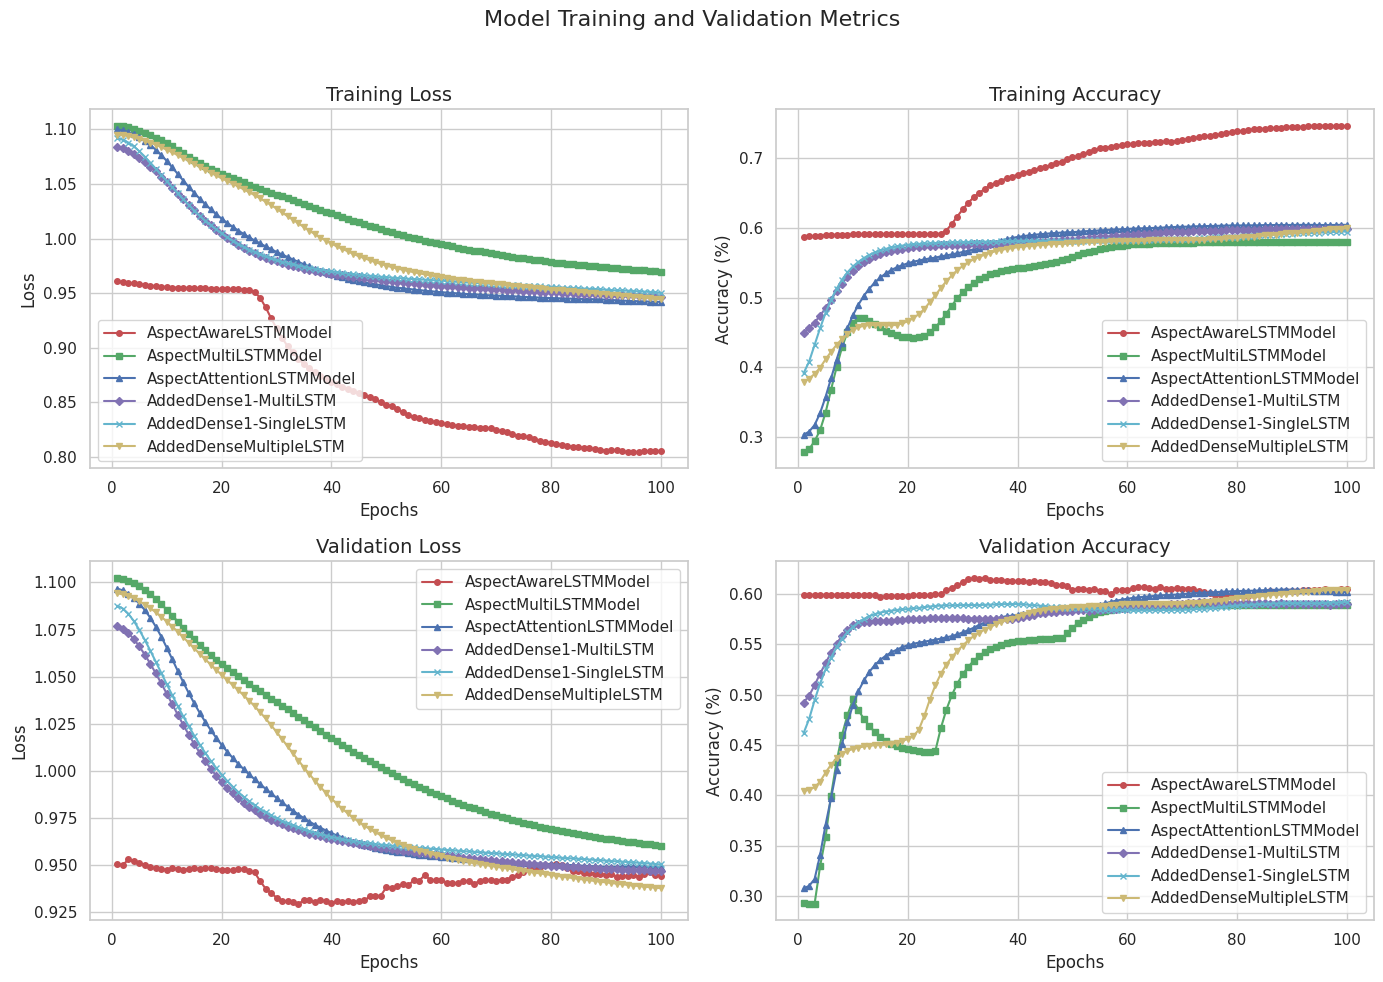

In [ ]:
epochs = range(1, len(train_losses_1) + 1)

# Set style
sns.set(style='whitegrid')

# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Training and Validation Metrics', fontsize=16)

# Plot training loss
axes[0, 0].plot(epochs, smooth_curve(train_losses_1), 'r-', label='AspectAwareLSTMModel', marker='o', markersize=4)
axes[0, 0].plot(epochs, smooth_curve(train_losses_2), 'g-', label='AspectMultiLSTMModel', marker='s', markersize=4)
axes[0, 0].plot(epochs, smooth_curve(train_losses_3), 'b-', label='AspectAttentionLSTMModel', marker='^', markersize=4)
axes[0, 0].plot(epochs, smooth_curve(train_losses_4), 'm-', label='AddedDense1-MultiLSTM', marker='D', markersize=4)
axes[0, 0].plot(epochs, smooth_curve(train_losses_5), 'c-', label='AddedDense1-SingleLSTM', marker='x', markersize=4)
axes[0, 0].plot(epochs, smooth_curve(train_losses_6), 'y-', label='AddedDenseMultipleLSTM', marker='v', markersize=4)
axes[0, 0].set_title('Training Loss', fontsize=14)
axes[0, 0].set_xlabel('Epochs', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot training accuracy
axes[0, 1].plot(epochs, smooth_curve(train_accuracies_1), 'r-', label='AspectAwareLSTMModel', marker='o', markersize=4)
axes[0, 1].plot(epochs, smooth_curve(train_accuracies_2), 'g-', label='AspectMultiLSTMModel', marker='s', markersize=4)
axes[0, 1].plot(epochs, smooth_curve(train_accuracies_3), 'b-', label='AspectAttentionLSTMModel', marker='^', markersize=4)
axes[0, 1].plot(epochs, smooth_curve(train_accuracies_4), 'm-', label='AddedDense1-MultiLSTM', marker='D', markersize=4)
axes[0, 1].plot(epochs, smooth_curve(train_accuracies_5), 'c-', label='AddedDense1-SingleLSTM', marker='x', markersize=4)
axes[0, 1].plot(epochs, smooth_curve(train_accuracies_6), 'y-', label='AddedDenseMultipleLSTM', marker='v', markersize=4)
axes[0, 1].set_title('Training Accuracy', fontsize=14)
axes[0, 1].set_xlabel('Epochs', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot validation loss
axes[1, 0].plot(epochs, smooth_curve(val_losses_1), 'r-', label='AspectAwareLSTMModel', marker='o', markersize=4)
axes[1, 0].plot(epochs, smooth_curve(val_losses_2), 'g-', label='AspectMultiLSTMModel', marker='s', markersize=4)
axes[1, 0].plot(epochs, smooth_curve(val_losses_3), 'b-', label='AspectAttentionLSTMModel', marker='^', markersize=4)
axes[1, 0].plot(epochs, smooth_curve(val_losses_4), 'm-', label='AddedDense1-MultiLSTM', marker='D', markersize=4)
axes[1, 0].plot(epochs, smooth_curve(val_losses_5), 'c-', label='AddedDense1-SingleLSTM', marker='x', markersize=4)
axes[1, 0].plot(epochs, smooth_curve(val_losses_6), 'y-', label='AddedDenseMultipleLSTM', marker='v', markersize=4)
axes[1, 0].set_title('Validation Loss', fontsize=14)
axes[1, 0].set_xlabel('Epochs', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot validation accuracy
axes[1, 1].plot(epochs, smooth_curve(val_accuracies_1), 'r-', label='AspectAwareLSTMModel', marker='o', markersize=4)
axes[1, 1].plot(epochs, smooth_curve(val_accuracies_2), 'g-', label='AspectMultiLSTMModel', marker='s', markersize=4)
axes[1, 1].plot(epochs, smooth_curve(val_accuracies_3), 'b-', label='AspectAttentionLSTMModel', marker='^', markersize=4)
axes[1, 1].plot(epochs, smooth_curve(val_accuracies_4), 'm-', label='AddedDense1-MultiLSTM', marker='D', markersize=4)
axes[1, 1].plot(epochs, smooth_curve(val_accuracies_5), 'c-', label='AddedDense1-SingleLSTM', marker='x', markersize=4)
axes[1, 1].plot(epochs, smooth_curve(val_accuracies_6), 'y-', label='AddedDenseMultipleLSTM', marker='v', markersize=4)
axes[1, 1].set_title('Validation Accuracy', fontsize=14)
axes[1, 1].set_xlabel('Epochs', fontsize=12)
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plots
plt.show()

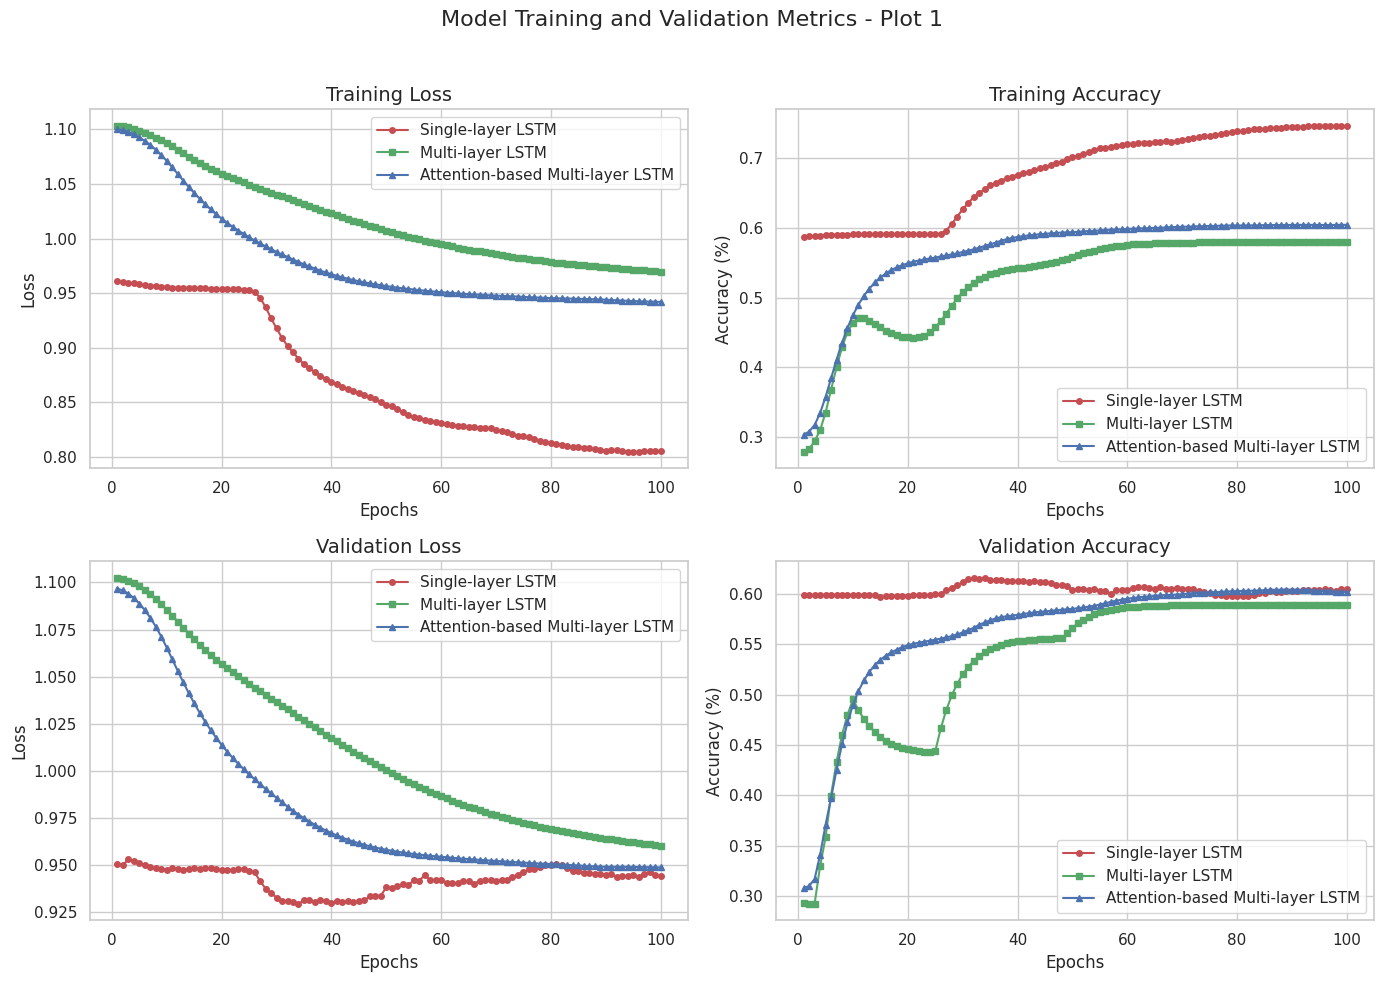

In [ ]:
epochs = range(1, len(train_losses_1) + 1)

# Set style
sns.set(style='whitegrid')

# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Create subplots for plot 1
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Training and Validation Metrics - Plot 1', fontsize=16)

# Plot training loss
axes[0, 0].plot(epochs, smooth_curve(train_losses_1), 'r-', label='Single-layer LSTM', marker='o', markersize=4)
axes[0, 0].plot(epochs, smooth_curve(train_losses_2), 'g-', label='Multi-layer LSTM', marker='s', markersize=4)
axes[0, 0].plot(epochs, smooth_curve(train_losses_3), 'b-', label='Attention-based Multi-layer LSTM', marker='^', markersize=4)
axes[0, 0].set_title('Training Loss', fontsize=14)
axes[0, 0].set_xlabel('Epochs', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot training accuracy
axes[0, 1].plot(epochs, smooth_curve(train_accuracies_1), 'r-', label='Single-layer LSTM', marker='o', markersize=4)
axes[0, 1].plot(epochs, smooth_curve(train_accuracies_2), 'g-', label='Multi-layer LSTM', marker='s', markersize=4)
axes[0, 1].plot(epochs, smooth_curve(train_accuracies_3), 'b-', label='Attention-based Multi-layer LSTM', marker='^', markersize=4)
axes[0, 1].set_title('Training Accuracy', fontsize=14)
axes[0, 1].set_xlabel('Epochs', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot validation loss
axes[1, 0].plot(epochs, smooth_curve(val_losses_1), 'r-', label='Single-layer LSTM', marker='o', markersize=4)
axes[1, 0].plot(epochs, smooth_curve(val_losses_2), 'g-', label='Multi-layer LSTM', marker='s', markersize=4)
axes[1, 0].plot(epochs, smooth_curve(val_losses_3), 'b-', label='Attention-based Multi-layer LSTM', marker='^', markersize=4)
axes[1, 0].set_title('Validation Loss', fontsize=14)
axes[1, 0].set_xlabel('Epochs', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot validation accuracy
axes[1, 1].plot(epochs, smooth_curve(val_accuracies_1), 'r-', label='Single-layer LSTM', marker='o', markersize=4)
axes[1, 1].plot(epochs, smooth_curve(val_accuracies_2), 'g-', label='Multi-layer LSTM', marker='s', markersize=4)
axes[1, 1].plot(epochs, smooth_curve(val_accuracies_3), 'b-', label='Attention-based Multi-layer LSTM', marker='^', markersize=4)
axes[1, 1].set_title('Validation Accuracy', fontsize=14)
axes[1, 1].set_xlabel('Epochs', fontsize=12)
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plots
plt.show()


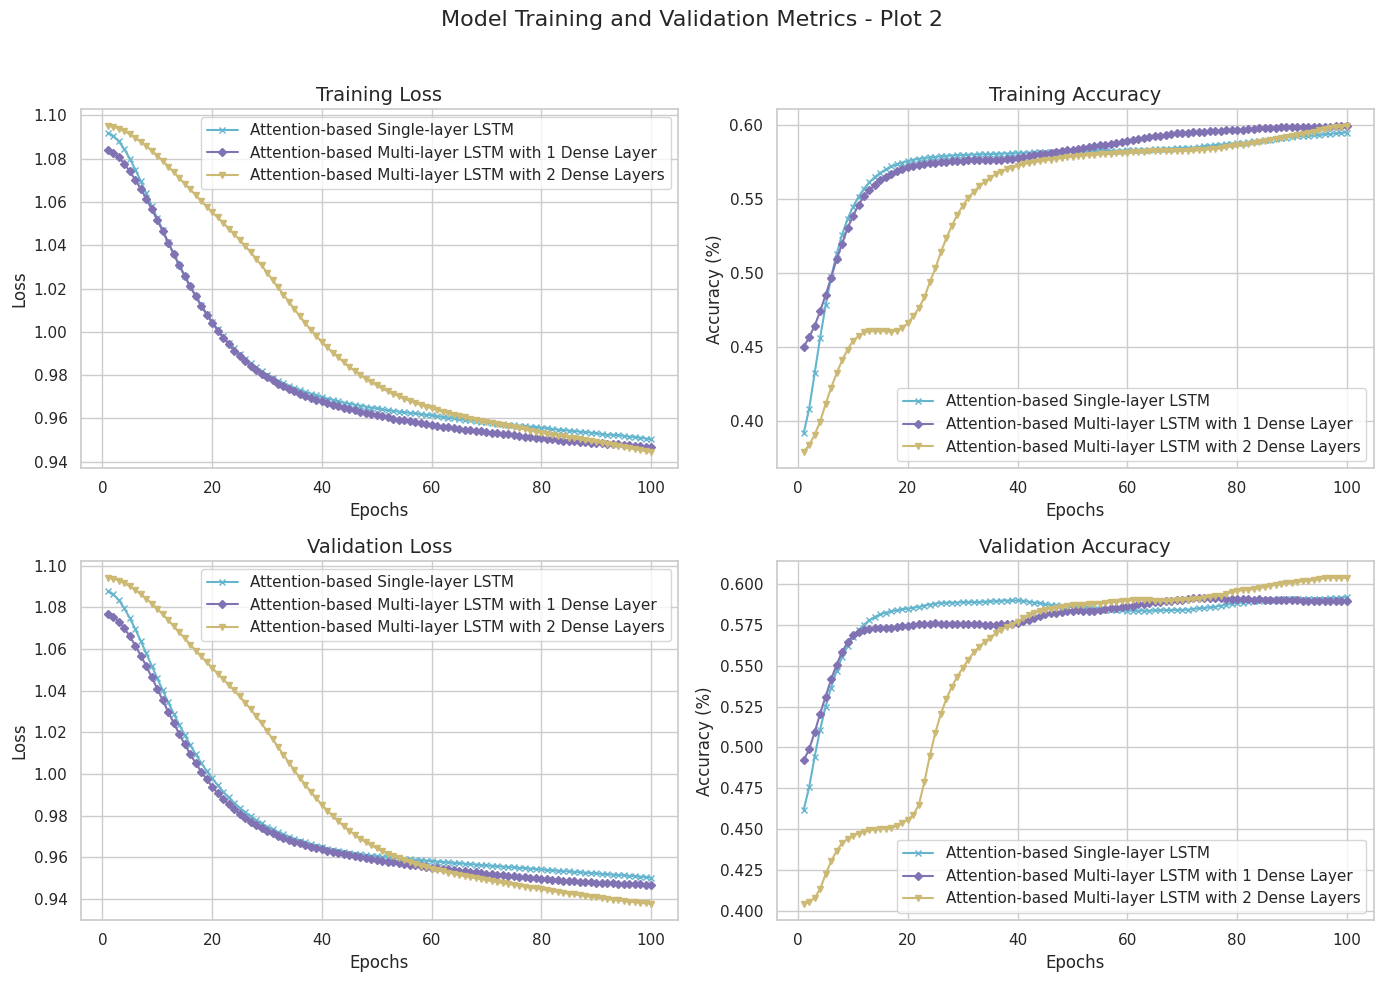

In [ ]:
epochs = range(1, len(train_losses_1) + 1)

# Set style
sns.set(style='whitegrid')

# Create subplots for plot 2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Training and Validation Metrics - Plot 2', fontsize=16)

# Plot training loss
axes[0, 0].plot(epochs, smooth_curve(train_losses_5), 'c-', label='Attention-based Single-layer LSTM', marker='x', markersize=4)
axes[0, 0].plot(epochs, smooth_curve(train_losses_4), 'm-', label='Attention-based Multi-layer LSTM with 1 Dense Layer', marker='D', markersize=4)
axes[0, 0].plot(epochs, smooth_curve(train_losses_6), 'y-', label='Attention-based Multi-layer LSTM with 2 Dense Layers', marker='v', markersize=4)
axes[0, 0].set_title('Training Loss', fontsize=14)
axes[0, 0].set_xlabel('Epochs', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot training accuracy
axes[0, 1].plot(epochs, smooth_curve(train_accuracies_5), 'c-', label='Attention-based Single-layer LSTM', marker='x', markersize=4)
axes[0, 1].plot(epochs, smooth_curve(train_accuracies_4), 'm-', label='Attention-based Multi-layer LSTM with 1 Dense Layer', marker='D', markersize=4)
axes[0, 1].plot(epochs, smooth_curve(train_accuracies_6), 'y-', label='Attention-based Multi-layer LSTM with 2 Dense Layers', marker='v', markersize=4)
axes[0, 1].set_title('Training Accuracy', fontsize=14)
axes[0, 1].set_xlabel('Epochs', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot validation loss
axes[1, 0].plot(epochs, smooth_curve(val_losses_5), 'c-', label='Attention-based Single-layer LSTM', marker='x', markersize=4)
axes[1, 0].plot(epochs, smooth_curve(val_losses_4), 'm-', label='Attention-based Multi-layer LSTM with 1 Dense Layer', marker='D', markersize=4)
axes[1, 0].plot(epochs, smooth_curve(val_losses_6), 'y-', label='Attention-based Multi-layer LSTM with 2 Dense Layers', marker='v', markersize=4)
axes[1, 0].set_title('Validation Loss', fontsize=14)
axes[1, 0].set_xlabel('Epochs', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot validation accuracy
axes[1, 1].plot(epochs, smooth_curve(val_accuracies_5), 'c-', label='Attention-based Single-layer LSTM', marker='x', markersize=4)
axes[1, 1].plot(epochs, smooth_curve(val_accuracies_4), 'm-', label='Attention-based Multi-layer LSTM with 1 Dense Layer', marker='D', markersize=4)
axes[1, 1].plot(epochs, smooth_curve(val_accuracies_6), 'y-', label='Attention-based Multi-layer LSTM with 2 Dense Layers', marker='v', markersize=4)
axes[1, 1].set_title('Validation Accuracy', fontsize=14)
axes[1, 1].set_xlabel('Epochs', fontsize=12)
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plots
plt.show()


In [ ]:
def visualize_attention(sentence, aspect, attention_weights, vocab, aspect_vocab):
    """
    Visualizes the attention weights between the words in a sentence and the aspects.
    
    Parameters:
    - sentence (Tensor): The tensor containing the indices of the words in the sentence.
    - aspect (Tensor): The tensor containing the indices of the aspect words.
    - attention_weights (Tensor): The tensor containing the attention weights.
    - vocab (dict): A dictionary mapping word indices to words for the sentence.
    - aspect_vocab (dict): A dictionary mapping word indices to words for the aspect.
    
    Returns:
    None
    """
        
    # Convert tensor to numpy arrays
    attention_weights = attention_weights.cpu().detach().numpy()
    sentence = sentence.cpu().detach().numpy()
    aspect = aspect.cpu().detach().numpy()

    # Convert indices to words
    sentence_words = [vocab[idx] for idx in sentence if idx in vocab]
    aspect_words = [aspect_vocab[idx] for idx in aspect if idx in aspect_vocab]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 2))

    # Plot attention weights
    attention_plot = ax.imshow(attention_weights, cmap='viridis', aspect='auto')

    # Set the ticks and labels
    ax.set_xticks(np.arange(len(sentence_words)))
    ax.set_yticks(np.arange(len(aspect_words)))
    ax.set_xticklabels(sentence_words, rotation=90)
    ax.set_yticklabels(aspect_words)

    # Add color bar
    cbar = ax.figure.colorbar(attention_plot, ax=ax)
    cbar.ax.set_ylabel("Attention Weight", rotation=-90, va="bottom")

    # Show the plot
    plt.show()

In [ ]:
# Sample indices from test set (choose as per your test set)
sample_indices = [0, 1]

# Retrieve the samples
sample_sentences = [test_loader.dataset[i][0] for i in sample_indices]
sample_aspects = [test_loader.dataset[i][1] for i in sample_indices]
sample_labels = [test_loader.dataset[i][2] for i in sample_indices]

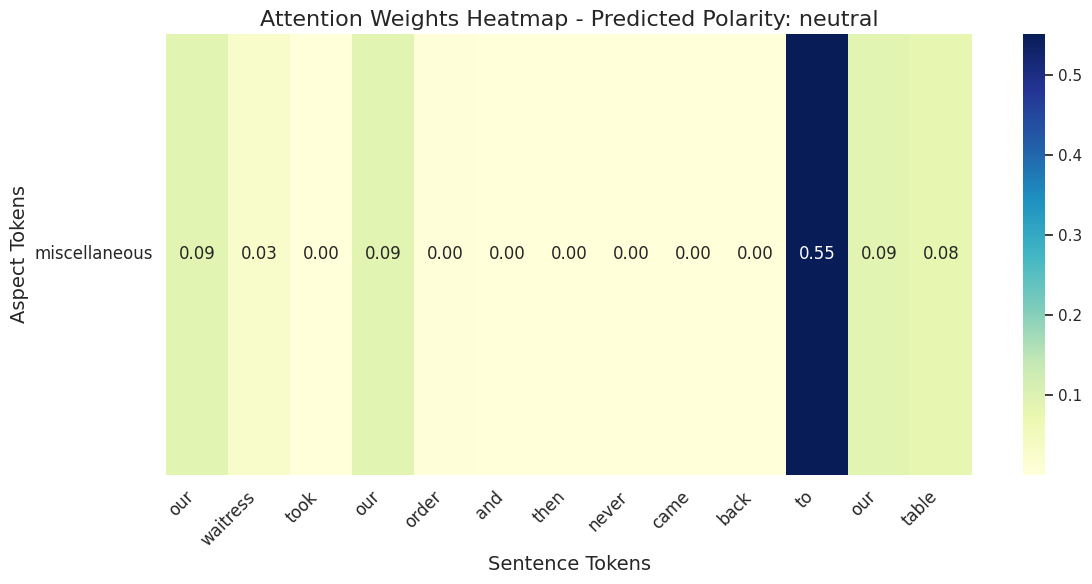

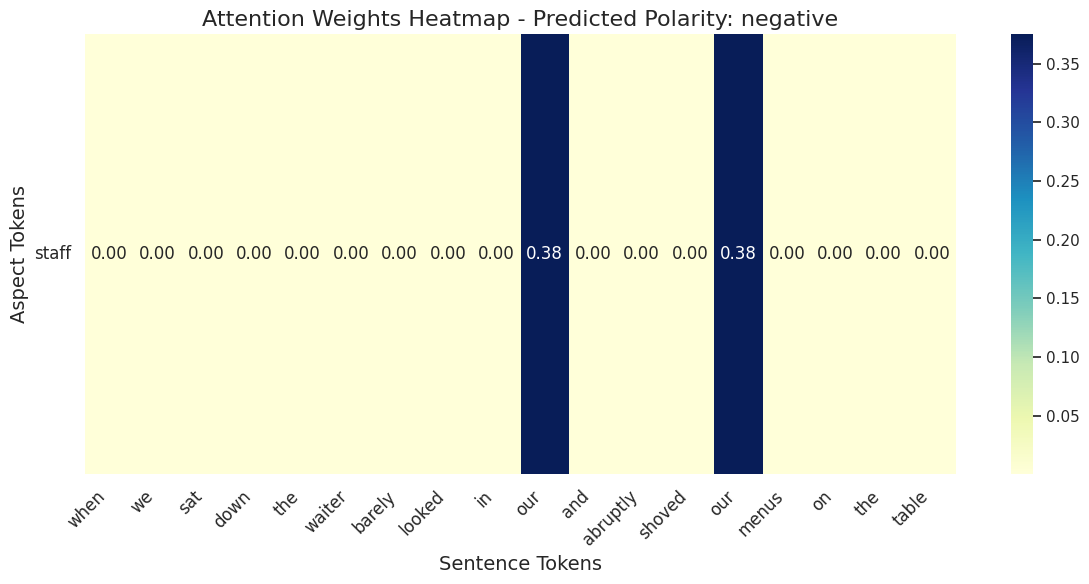

In [ ]:
# Select a few samples from the test set
sample_indices = [11, 12]  # You can change these indices to choose different samples
test_samples = [(test_sentence[i], test_aspects[i], test_labels[i]) for i in sample_indices]

# Get the attention weights for the selected samples
model_AddedDense1.eval()
attention_weights_list = []

with torch.no_grad():
    for sentences, aspects, labels in test_samples:
        sentences, aspects, labels = sentences.unsqueeze(0).to(device), aspects.unsqueeze(0).to(device), labels.to(device)
        outputs, attention_weights = model_AddedDense1(sentences, aspects)
        attention_weights_list.append(attention_weights.squeeze().cpu().numpy())

# Function to plot attention weights
def plot_attention_weights(sentence, aspect, attention_weights, vocab, title):
    inverse_vocab = {v: k for k, v in vocab.items()}
    sentence_tokens = [inverse_vocab[token] for token in sentence if inverse_vocab[token] != 'UNK']
    attention_weights = [weight for token, weight in zip(sentence, attention_weights) if inverse_vocab[token] != 'UNK']
    aspect_token = inverse_vocab.get(aspect.item(), 'UNK')

    plt.figure(figsize=(12, 6))
    sns.heatmap([attention_weights], xticklabels=sentence_tokens, yticklabels=[aspect_token], cmap="YlGnBu", cbar=True, annot=True, fmt=".2f", annot_kws={"size": 12})
    plt.xlabel('Sentence Tokens', fontsize=14)
    plt.ylabel('Aspect Tokens', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot attention weights for the selected samples
for i, (sentence, aspect, attention_weights) in enumerate(zip(test_sentence[sample_indices], test_aspects[sample_indices], attention_weights_list)):
    outputs, _ = model_AddedDense1(sentence.unsqueeze(0).to(device), aspect.unsqueeze(0).to(device))
    predicted_label = label_encoder.inverse_transform([torch.argmax(outputs, dim=1).cpu().numpy()[0]])[0]
    plot_attention_weights(sentence.cpu().numpy(), aspect, attention_weights, vocab, f'Attention Weights Heatmap - Predicted Polarity: {predicted_label}')

# Optimization Code:

In [ ]:
# Assuming necessary imports and data loaders are defined:
# - train_loader
# - val_loader
# - test_loader
# - vocab
# - label_encoder
# - device (CPU or GPU)

# Define the model classes
class AspectAwareLSTMModel(nn.Module):
    def __init__(self, vocab_size, aspect_vocab_size, embedding_dim, aspect_embedding_dim, lstm_units, num_classes, dropout_rate=0.25):
        super(AspectAwareLSTMModel, self).__init__()
        self.sentence_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.aspect_embedding = nn.Embedding(aspect_vocab_size, aspect_embedding_dim)
        self.sentence_lstm = nn.LSTM(embedding_dim, lstm_units, batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.fc = nn.Linear(lstm_units * 2 + aspect_embedding_dim, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, sentence, aspect):
        sentence_embeds = self.sentence_embedding(sentence)
        aspect_embeds = self.aspect_embedding(aspect)
        lstm_out, _ = self.sentence_lstm(sentence_embeds)
        combined_embeds = torch.cat((lstm_out[:, -1, :], aspect_embeds), dim=1)
        output = self.dropout(combined_embeds)
        output = self.fc(output)
        return torch.softmax(output, dim=1)

class AspectMultiLSTMModel(nn.Module):
    def __init__(self, vocab_size, aspect_vocab_size, embedding_dim, aspect_embedding_dim, lstm_units, num_classes, num_layers=3, dropout_rate=0.25):
        super(AspectMultiLSTMModel, self).__init__()
        self.sentence_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.aspect_embedding = nn.Embedding(aspect_vocab_size, aspect_embedding_dim)
        self.sentence_lstm = nn.LSTM(embedding_dim, lstm_units, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(lstm_units * 2 + aspect_embedding_dim, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, sentence, aspect):
        sentence_embeds = self.sentence_embedding(sentence)
        aspect_embeds = self.aspect_embedding(aspect)
        lstm_out, _ = self.sentence_lstm(sentence_embeds)
        combined_embeds = torch.cat((lstm_out[:, -1, :], aspect_embeds), dim=1)
        output = self.dropout(combined_embeds)
        output = self.fc(output)
        return torch.softmax(output, dim=1)

class AspectAttentionLSTMModel(nn.Module):
    def __init__(self, vocab_size, aspect_vocab_size, embedding_dim, aspect_embedding_dim, lstm_units, num_classes, num_layers=3, dropout_rate=0.25):
        super(AspectAttentionLSTMModel, self).__init__()
        self.sentence_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.aspect_embedding = nn.Embedding(aspect_vocab_size, aspect_embedding_dim)
        self.attention_fc_key = nn.Linear(embedding_dim, lstm_units)
        self.attention_fc_value = nn.Linear(embedding_dim, lstm_units)
        self.attention_fc_query = nn.Linear(aspect_embedding_dim, lstm_units)
        self.attention_softmax = nn.Softmax(dim=1)
        self.sentence_lstm = nn.LSTM(embedding_dim, lstm_units, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=dropout_rate if num_layers > 1 else 0)
        self.intermediate_fc = nn.Linear(lstm_units * 2 + lstm_units + aspect_embedding_dim, lstm_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(lstm_units, num_classes)

    def forward(self, sentence, aspect):
        sentence_embeds = self.sentence_embedding(sentence)
        aspect_embeds = self.aspect_embedding(aspect)
        key = self.attention_fc_key(sentence_embeds)
        value = self.attention_fc_value(sentence_embeds)
        query = self.attention_fc_query(aspect_embeds).unsqueeze(1)
        attention_weights = self.attention_softmax(torch.bmm(query, key.transpose(1, 2)).squeeze(1))
        context_vector = torch.sum(attention_weights.unsqueeze(2) * value, dim=1)
        sentence_lstm_out, _ = self.sentence_lstm(sentence_embeds)
        combined_embeds = torch.cat((sentence_lstm_out[:, -1, :], context_vector, aspect_embeds), dim=1)
        intermediate_output = self.intermediate_fc(combined_embeds)
        intermediate_output = self.dropout(intermediate_output)
        out = self.fc(intermediate_output)
        out = torch.softmax(out, dim=1)
        return out, attention_weights

# Define the training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_corrects = 0
        total_train_samples = 0

        for sentences, aspects, labels in train_loader:
            sentences = sentences.to(device)
            aspects = aspects.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            if isinstance(model, (AspectMultiLSTMModel, AspectAttentionLSTMModel, AspectAwareLSTMModel)):
                outputs = model(sentences, aspects)
            else:
                outputs = model(sentences, aspects)

            if isinstance(model, AspectAttentionLSTMModel):
                outputs, _ = outputs  # Ignore attention weights

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * sentences.size(0)
            _, preds = torch.max(outputs, 1)
            epoch_train_corrects += torch.sum(preds == labels).item()
            total_train_samples += sentences.size(0)

        epoch_train_loss /= total_train_samples
        epoch_train_accuracy = epoch_train_corrects / total_train_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        model.eval()
        epoch_val_loss = 0
        epoch_val_corrects = 0
        total_val_samples = 0

        with torch.no_grad():
            for sentences, aspects, labels in val_loader:
                sentences = sentences.to(device)
                aspects = aspects.to(device)
                labels = labels.to(device)

                if isinstance(model, (AspectMultiLSTMModel, AspectAttentionLSTMModel, AspectAwareLSTMModel)):
                    outputs = model(sentences, aspects)
                else:
                    outputs = model(sentences, aspects)

                if isinstance(model, AspectAttentionLSTMModel):
                    outputs, _ = outputs  # Ignore attention weights

                loss = criterion(outputs, labels)

                epoch_val_loss += loss.item() * sentences.size(0)
                _, preds = torch.max(outputs, 1)
                epoch_val_corrects += torch.sum(preds == labels).item()
                total_val_samples += sentences.size(0)

        epoch_val_loss /= total_val_samples
        epoch_val_accuracy = epoch_val_corrects / total_val_samples
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f} Val Accuracy: {epoch_val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Define hyperparameters
vocab_size = len(vocab)
aspect_vocab_size = len(vocab)  # Assuming same vocab size for aspect and sentence
lstm_units = 128
num_classes = len(label_encoder.classes_)
num_layers = 3
dropout_rate = 0.25
num_epochs = 100

# Parameters to be cycled through
learning_rates = [1e-8, 1e-7, 1e-6]
embedding_dims = [100, 150, 200]
aspect_embedding_dims = [50, 100, 150]

# Train AspectAwareLSTMModel with different learning rates
model1_lr = AspectAwareLSTMModel(vocab_size, aspect_vocab_size, embedding_dims[0], aspect_embedding_dims[0], lstm_units, num_classes, dropout_rate).to(device)
optimizers_1_lr = [optim.Adam(model1_lr.parameters(), lr=lr) for lr in learning_rates]

train_losses_lr_1 = []
val_losses_lr_1 = []
train_accuracies_lr_1 = []
val_accuracies_lr_1 = []
for i, optimizer in enumerate(optimizers_1_lr):
    print(f"Training AspectAwareLSTMModel with learning rate {learning_rates[i]}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model1_lr, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    train_losses_lr_1.append(train_losses)
    val_losses_lr_1.append(val_losses)
    train_accuracies_lr_1.append(train_accuracies)
    val_accuracies_lr_1.append(val_accuracies)

# Train models for different embedding dimensions
train_losses_emb_1 = []
val_losses_emb_1 = []
train_accuracies_emb_1 = []
val_accuracies_emb_1 = []
for emb_dim in embedding_dims:
    model = AspectAwareLSTMModel(vocab_size, aspect_vocab_size, emb_dim, aspect_embedding_dims[0], lstm_units, num_classes, dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rates[0])
    print(f"Training AspectAwareLSTMModel with embedding dimension {emb_dim}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    train_losses_emb_1.append(train_losses)
    val_losses_emb_1.append(val_losses)
    train_accuracies_emb_1.append(train_accuracies)
    val_accuracies_emb_1.append(val_accuracies)

# Train models for different aspect embedding dimensions
train_losses_asp_1 = []
val_losses_asp_1 = []
train_accuracies_asp_1 = []
val_accuracies_asp_1 = []
for asp_dim in aspect_embedding_dims:
    model = AspectAwareLSTMModel(vocab_size, aspect_vocab_size, embedding_dims[0], asp_dim, lstm_units, num_classes, dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rates[0])
    print(f"Training AspectAwareLSTMModel with aspect embedding dimension {asp_dim}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    train_losses_asp_1.append(train_losses)
    val_losses_asp_1.append(val_losses)
    train_accuracies_asp_1.append(train_accuracies)
    val_accuracies_asp_1.append(val_accuracies)

# Train AspectMultiLSTMModel with different learning rates
model2_lr = AspectMultiLSTMModel(vocab_size, aspect_vocab_size, embedding_dims[0], aspect_embedding_dims[0], lstm_units, num_classes, num_layers, dropout_rate).to(device)
optimizers_2_lr = [optim.Adam(model2_lr.parameters(), lr=lr) for lr in learning_rates]

train_losses_lr_2 = []
val_losses_lr_2 = []
train_accuracies_lr_2 = []
val_accuracies_lr_2 = []
for i, optimizer in enumerate(optimizers_2_lr):
    print(f"Training AspectMultiLSTMModel with learning rate {learning_rates[i]}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model2_lr, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    train_losses_lr_2.append(train_losses)
    val_losses_lr_2.append(val_losses)
    train_accuracies_lr_2.append(train_accuracies)
    val_accuracies_lr_2.append(val_accuracies)

# Train models for different embedding dimensions
train_losses_emb_2 = []
val_losses_emb_2 = []
train_accuracies_emb_2 = []
val_accuracies_emb_2 = []
for emb_dim in embedding_dims:
    model = AspectMultiLSTMModel(vocab_size, aspect_vocab_size, emb_dim, aspect_embedding_dims[0], lstm_units, num_classes, num_layers, dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rates[0])
    print(f"Training AspectMultiLSTMModel with embedding dimension {emb_dim}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    train_losses_emb_2.append(train_losses)
    val_losses_emb_2.append(val_losses)
    train_accuracies_emb_2.append(train_accuracies)
    val_accuracies_emb_2.append(val_accuracies)

# Train models for different aspect embedding dimensions
train_losses_asp_2 = []
val_losses_asp_2 = []
train_accuracies_asp_2 = []
val_accuracies_asp_2 = []
for asp_dim in aspect_embedding_dims:
    model = AspectMultiLSTMModel(vocab_size, aspect_vocab_size, embedding_dims[0], asp_dim, lstm_units, num_classes, num_layers, dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rates[0])
    print(f"Training AspectMultiLSTMModel with aspect embedding dimension {asp_dim}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    train_losses_asp_2.append(train_losses)
    val_losses_asp_2.append(val_losses)
    train_accuracies_asp_2.append(train_accuracies)
    val_accuracies_asp_2.append(val_accuracies)

# Train AspectAttentionLSTMModel with different learning rates
model3_lr = AspectAttentionLSTMModel(vocab_size, aspect_vocab_size, embedding_dims[0], aspect_embedding_dims[0], lstm_units, num_classes, num_layers, dropout_rate).to(device)
optimizers_3_lr = [optim.Adam(model3_lr.parameters(), lr=lr) for lr in learning_rates]

train_losses_lr_3 = []
val_losses_lr_3 = []
train_accuracies_lr_3 = []
val_accuracies_lr_3 = []
for i, optimizer in enumerate(optimizers_3_lr):
    print(f"Training AspectAttentionLSTMModel with learning rate {learning_rates[i]}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model3_lr, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    train_losses_lr_3.append(train_losses)
    val_losses_lr_3.append(val_losses)
    train_accuracies_lr_3.append(train_accuracies)
    val_accuracies_lr_3.append(val_accuracies)

# Train models for different embedding dimensions
train_losses_emb_3 = []
val_losses_emb_3 = []
train_accuracies_emb_3 = []
val_accuracies_emb_3 = []
for emb_dim in embedding_dims:
    model = AspectAttentionLSTMModel(vocab_size, aspect_vocab_size, emb_dim, aspect_embedding_dims[0], lstm_units, num_classes, num_layers, dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rates[0])
    print(f"Training AspectAttentionLSTMModel with embedding dimension {emb_dim}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    train_losses_emb_3.append(train_losses)
    val_losses_emb_3.append(val_losses)
    train_accuracies_emb_3.append(train_accuracies)
    val_accuracies_emb_3.append(val_accuracies)

# Train models for different aspect embedding dimensions
train_losses_asp_3 = []
val_losses_asp_3 = []
train_accuracies_asp_3 = []
val_accuracies_asp_3 = []
for asp_dim in aspect_embedding_dims:
    model = AspectAttentionLSTMModel(vocab_size, aspect_vocab_size, embedding_dims[0], asp_dim, lstm_units, num_classes, num_layers, dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rates[0])
    print(f"Training AspectAttentionLSTMModel with aspect embedding dimension {asp_dim}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    train_losses_asp_3.append(train_losses)
    val_losses_asp_3.append(val_losses)
    train_accuracies_asp_3.append(train_accuracies)
    val_accuracies_asp_3.append(val_accuracies)

# Plotting results
# Define the labels for each variation
labels = [
    'AspectAwareLSTMModel - LR Variation 1', 'AspectAwareLSTMModel - LR Variation 2', 'AspectAwareLSTMModel - LR Variation 3',
    'AspectAwareLSTMModel - Embedding Dimension Variation 1', 'AspectAwareLSTMModel - Embedding Dimension Variation 2', 'AspectAwareLSTMModel - Embedding Dimension Variation 3',
    'AspectAwareLSTMModel - Aspect Dimension Variation 1', 'AspectAwareLSTMModel - Aspect Dimension Variation 2', 'AspectAwareLSTMModel - Aspect Dimension Variation 3',
    'AspectMultiLSTMModel - LR Variation 1', 'AspectMultiLSTMModel - LR Variation 2', 'AspectMultiLSTMModel - LR Variation 3',
    'AspectMultiLSTMModel - Embedding Dimension Variation 1', 'AspectMultiLSTMModel - Embedding Dimension Variation 2', 'AspectMultiLSTMModel - Embedding Dimension Variation 3',
    'AspectMultiLSTMModel - Aspect Dimension Variation 1', 'AspectMultiLSTMModel - Aspect Dimension Variation 2', 'AspectMultiLSTMModel - Aspect Dimension Variation 3',
    'AspectAttentionLSTMModel - LR Variation 1', 'AspectAttentionLSTMModel - LR Variation 2', 'AspectAttentionLSTMModel - LR Variation 3',
    'AspectAttentionLSTMModel - Embedding Dimension Variation 1', 'AspectAttentionLSTMModel - Embedding Dimension Variation 2', 'AspectAttentionLSTMModel - Embedding Dimension Variation 3',
    'AspectAttentionLSTMModel - Aspect Dimension Variation 1', 'AspectAttentionLSTMModel - Aspect Dimension Variation 2', 'AspectAttentionLSTMModel - Aspect Dimension Variation 3'
]

# Use a Seaborn color palette
colors = sns.color_palette("Set2", len(labels))

# Example epochs range
epochs = range(num_epochs)

# Example training and validation losses (replace with actual losses)
train_losses = train_losses_lr_1 + train_losses_emb_1 + train_losses_asp_1 + train_losses_lr_2 + train_losses_emb_2 + train_losses_asp_2 + train_losses_lr_3 + train_losses_emb_3 + train_losses_asp_3
val_losses = val_losses_lr_1 + val_losses_emb_1 + val_losses_asp_1 + val_losses_lr_2 + val_losses_emb_2 + val_losses_asp_2 + val_losses_lr_3 + val_losses_emb_3 + val_losses_asp_3

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot training losses
for i, label in enumerate(labels):
    ax1.plot(epochs, train_losses[i], label=f'Train Loss - {label}', color=colors[i], linestyle='-', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)

# Plot validation losses
for i, label in enumerate(labels):
    ax2.plot(epochs, val_losses[i], label=f'Val Loss - {label}', color=colors[i], linestyle='--', marker='x')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss')
ax2.grid(True)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)

# Main title
fig.suptitle('Train and Validation Loss Over Epochs', fontsize=16)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# example runtime execution:
Training AspectAwareLSTMModel with learning rate 1e-08
Epoch 1/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1077 Val Accuracy: 0.3649
Epoch 2/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1077 Val Accuracy: 0.3649
Epoch 3/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1076 Val Accuracy: 0.3649
Epoch 4/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1076 Val Accuracy: 0.3649
Epoch 5/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1075 Val Accuracy: 0.3649
Epoch 6/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1075 Val Accuracy: 0.3649
Epoch 7/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1075 Val Accuracy: 0.3649
Epoch 8/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1074 Val Accuracy: 0.3649
Epoch 9/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1074 Val Accuracy: 0.3649
Epoch 10/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1073 Val Accuracy: 0.3649
Epoch 11/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1073 Val Accuracy: 0.3649
Epoch 12/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1073 Val Accuracy: 0.3649
Epoch 13/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1072 Val Accuracy: 0.3649
Epoch 14/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1072 Val Accuracy: 0.3592
Epoch 15/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1071 Val Accuracy: 0.3592
Epoch 16/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1071 Val Accuracy: 0.3592
Epoch 17/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1071 Val Accuracy: 0.3604
Epoch 18/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1070 Val Accuracy: 0.3615
Epoch 19/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1070 Val Accuracy: 0.3615
Epoch 20/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1069 Val Accuracy: 0.3615
Epoch 21/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1069 Val Accuracy: 0.3615
Epoch 22/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1069 Val Accuracy: 0.3615
Epoch 23/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1068 Val Accuracy: 0.3615
Epoch 24/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1068 Val Accuracy: 0.3615
Epoch 25/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1067 Val Accuracy: 0.3615
Epoch 26/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1067 Val Accuracy: 0.3491
Epoch 27/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1067 Val Accuracy: 0.3547
Epoch 28/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1066 Val Accuracy: 0.3547
Epoch 29/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1066 Val Accuracy: 0.3547
Epoch 30/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1065 Val Accuracy: 0.3547
Epoch 31/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1065 Val Accuracy: 0.3547
Epoch 32/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1065 Val Accuracy: 0.3547
Epoch 33/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1064 Val Accuracy: 0.3547
Epoch 34/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1064 Val Accuracy: 0.3547
Epoch 35/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1063 Val Accuracy: 0.3547
Epoch 36/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1063 Val Accuracy: 0.3547
Epoch 37/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1063 Val Accuracy: 0.3547
Epoch 38/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1062 Val Accuracy: 0.3547
Epoch 39/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1062 Val Accuracy: 0.3547
Epoch 40/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1061 Val Accuracy: 0.3547
Epoch 41/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1061 Val Accuracy: 0.3547
Epoch 42/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1061 Val Accuracy: 0.3547
Epoch 43/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1060 Val Accuracy: 0.3547
Epoch 44/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1060 Val Accuracy: 0.3547
Epoch 45/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1059 Val Accuracy: 0.3547
Epoch 46/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1059 Val Accuracy: 0.3547
Epoch 47/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1059 Val Accuracy: 0.3547
Epoch 48/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1058 Val Accuracy: 0.3547
Epoch 49/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1058 Val Accuracy: 0.3547
Epoch 50/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1058 Val Accuracy: 0.3547
Epoch 51/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1057 Val Accuracy: 0.3547
Epoch 52/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1057 Val Accuracy: 0.3547
Epoch 53/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1056 Val Accuracy: 0.3547
Epoch 54/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1056 Val Accuracy: 0.3547
Epoch 55/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1056 Val Accuracy: 0.3547
Epoch 56/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1055 Val Accuracy: 0.3547
Epoch 57/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1055 Val Accuracy: 0.3547
Epoch 58/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1054 Val Accuracy: 0.3547
Epoch 59/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1054 Val Accuracy: 0.3547
Epoch 60/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1054 Val Accuracy: 0.3559
Epoch 61/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1053 Val Accuracy: 0.3716
Epoch 62/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1053 Val Accuracy: 0.3716
Epoch 63/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1052 Val Accuracy: 0.3716
Epoch 64/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1052 Val Accuracy: 0.3716
Epoch 65/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1052 Val Accuracy: 0.3716
Epoch 66/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1051 Val Accuracy: 0.3727
Epoch 67/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1051 Val Accuracy: 0.3727
Epoch 68/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1050 Val Accuracy: 0.3727
Epoch 69/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1050 Val Accuracy: 0.3727
Epoch 70/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1050 Val Accuracy: 0.3727
Epoch 71/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1049 Val Accuracy: 0.3727
Epoch 72/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1049 Val Accuracy: 0.3727
Epoch 73/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1048 Val Accuracy: 0.3727
Epoch 74/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1048 Val Accuracy: 0.3727
Epoch 75/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1048 Val Accuracy: 0.3727
Epoch 76/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1047 Val Accuracy: 0.3727
Epoch 77/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1047 Val Accuracy: 0.3727
Epoch 78/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1046 Val Accuracy: 0.3727
Epoch 79/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1046 Val Accuracy: 0.3727
Epoch 80/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1046 Val Accuracy: 0.3739
Epoch 81/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1045 Val Accuracy: 0.3739
Epoch 82/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1045 Val Accuracy: 0.3739
Epoch 83/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1044 Val Accuracy: 0.3739
Epoch 84/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1044 Val Accuracy: 0.3739
Epoch 85/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1044 Val Accuracy: 0.3739
Epoch 86/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1043 Val Accuracy: 0.3750
Epoch 87/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1043 Val Accuracy: 0.3750
Epoch 88/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1042 Val Accuracy: 0.3750
Epoch 89/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1042 Val Accuracy: 0.3750
Epoch 90/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1042 Val Accuracy: 0.3750
Epoch 91/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1041 Val Accuracy: 0.3750
Epoch 92/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1041 Val Accuracy: 0.3750
Epoch 93/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1040 Val Accuracy: 0.3750
Epoch 94/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1040 Val Accuracy: 0.3750
Epoch 95/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1040 Val Accuracy: 0.3750
Epoch 96/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1039 Val Accuracy: 0.3750
Epoch 97/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1039 Val Accuracy: 0.3750
Epoch 98/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1038 Val Accuracy: 0.3750
Epoch 99/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1038 Val Accuracy: 0.3750
Epoch 100/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1038 Val Accuracy: 0.3750
Training AspectAwareLSTMModel with learning rate 1e-07
Epoch 1/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1034 Val Accuracy: 0.3750
Epoch 2/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1030 Val Accuracy: 0.3750
Epoch 3/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1026 Val Accuracy: 0.3750
Epoch 4/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1022 Val Accuracy: 0.3750
Epoch 5/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1018 Val Accuracy: 0.3750
Epoch 6/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1014 Val Accuracy: 0.3750
Epoch 7/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1010 Val Accuracy: 0.3750
Epoch 8/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1006 Val Accuracy: 0.3750
Epoch 9/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1002 Val Accuracy: 0.3750
Epoch 10/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0998 Val Accuracy: 0.3750
Epoch 11/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0994 Val Accuracy: 0.3750
Epoch 12/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0990 Val Accuracy: 0.3750
Epoch 13/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0986 Val Accuracy: 0.4167
Epoch 14/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0982 Val Accuracy: 0.4167
Epoch 15/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0978 Val Accuracy: 0.4167
Epoch 16/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0974 Val Accuracy: 0.4167
Epoch 17/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0970 Val Accuracy: 0.4167
Epoch 18/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0966 Val Accuracy: 0.4167
Epoch 19/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0962 Val Accuracy: 0.5214
Epoch 20/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0958 Val Accuracy: 0.5214
Epoch 21/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0954 Val Accuracy: 0.5214
Epoch 22/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0950 Val Accuracy: 0.5214
Epoch 23/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0946 Val Accuracy: 0.5203
Epoch 24/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0942 Val Accuracy: 0.5203
Epoch 25/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0938 Val Accuracy: 0.5203
Epoch 26/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0934 Val Accuracy: 0.5203
Epoch 27/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0930 Val Accuracy: 0.5203
Epoch 28/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0927 Val Accuracy: 0.5203
Epoch 29/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0923 Val Accuracy: 0.5011
Epoch 30/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0919 Val Accuracy: 0.5000
Epoch 31/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0915 Val Accuracy: 0.5000
Epoch 32/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0911 Val Accuracy: 0.5000
Epoch 33/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0907 Val Accuracy: 0.5000
Epoch 34/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0903 Val Accuracy: 0.5000
Epoch 35/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0899 Val Accuracy: 0.3998
Epoch 36/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0896 Val Accuracy: 0.3863
Epoch 37/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0892 Val Accuracy: 0.3863
Epoch 38/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0888 Val Accuracy: 0.3851
Epoch 39/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0884 Val Accuracy: 0.3851
Epoch 40/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0880 Val Accuracy: 0.3829
Epoch 41/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0876 Val Accuracy: 0.3829
Epoch 42/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0873 Val Accuracy: 0.3829
Epoch 43/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0869 Val Accuracy: 0.3829
Epoch 44/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0865 Val Accuracy: 0.3829
Epoch 45/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0861 Val Accuracy: 0.3829
Epoch 46/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0858 Val Accuracy: 0.3829
Epoch 47/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0854 Val Accuracy: 0.3829
Epoch 48/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0850 Val Accuracy: 0.3829
Epoch 49/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0846 Val Accuracy: 0.3829
Epoch 50/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0842 Val Accuracy: 0.3829
Epoch 51/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0839 Val Accuracy: 0.3840
Epoch 52/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0835 Val Accuracy: 0.3840
Epoch 53/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0831 Val Accuracy: 0.3840
Epoch 54/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0827 Val Accuracy: 0.3840
Epoch 55/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0824 Val Accuracy: 0.4381
Epoch 56/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0820 Val Accuracy: 0.4392
Epoch 57/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0816 Val Accuracy: 0.4392
Epoch 58/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0813 Val Accuracy: 0.4392
Epoch 59/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0809 Val Accuracy: 0.4392
Epoch 60/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0806 Val Accuracy: 0.4392
Epoch 61/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0802 Val Accuracy: 0.4392
Epoch 62/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0798 Val Accuracy: 0.4392
Epoch 63/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0795 Val Accuracy: 0.4392
Epoch 64/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0791 Val Accuracy: 0.4392
Epoch 65/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0788 Val Accuracy: 0.4392
Epoch 66/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0784 Val Accuracy: 0.4392
Epoch 67/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0781 Val Accuracy: 0.4392
Epoch 68/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0777 Val Accuracy: 0.4381
Epoch 69/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0774 Val Accuracy: 0.4381
Epoch 70/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0770 Val Accuracy: 0.4381
Epoch 71/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0767 Val Accuracy: 0.4381
Epoch 72/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0763 Val Accuracy: 0.4381
Epoch 73/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0760 Val Accuracy: 0.4381
Epoch 74/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0757 Val Accuracy: 0.4381
Epoch 75/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0753 Val Accuracy: 0.4381
Epoch 76/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0750 Val Accuracy: 0.4381
Epoch 77/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0746 Val Accuracy: 0.4381
Epoch 78/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0743 Val Accuracy: 0.4381
Epoch 79/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0740 Val Accuracy: 0.4381
Epoch 80/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0736 Val Accuracy: 0.4381
Epoch 81/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0733 Val Accuracy: 0.4381
Epoch 82/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0730 Val Accuracy: 0.4381
Epoch 83/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0727 Val Accuracy: 0.4381
Epoch 84/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0723 Val Accuracy: 0.4381
Epoch 85/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0720 Val Accuracy: 0.4381
Epoch 86/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0717 Val Accuracy: 0.4381
Epoch 87/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0714 Val Accuracy: 0.4381
Epoch 88/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0710 Val Accuracy: 0.4381
Epoch 89/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0707 Val Accuracy: 0.4381
Epoch 90/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0704 Val Accuracy: 0.4381
Epoch 91/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0701 Val Accuracy: 0.4381
Epoch 92/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0698 Val Accuracy: 0.4381
Epoch 93/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0695 Val Accuracy: 0.4381
Epoch 94/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0691 Val Accuracy: 0.4381
Epoch 95/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0688 Val Accuracy: 0.4381
Epoch 96/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0685 Val Accuracy: 0.4381
Epoch 97/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0682 Val Accuracy: 0.4381
Epoch 98/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0679 Val Accuracy: 0.4381
Epoch 99/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0676 Val Accuracy: 0.4381
Epoch 100/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0673 Val Accuracy: 0.4381
Training AspectAwareLSTMModel with learning rate 1e-06
Epoch 1/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0644 Val Accuracy: 0.4381
Epoch 2/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0617 Val Accuracy: 0.4392
Epoch 3/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0591 Val Accuracy: 0.4403
Epoch 4/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0567 Val Accuracy: 0.4403
Epoch 5/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0543 Val Accuracy: 0.4403
Epoch 6/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0521 Val Accuracy: 0.4437
Epoch 7/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0499 Val Accuracy: 0.5574
Epoch 8/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0478 Val Accuracy: 0.5574
Epoch 9/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0457 Val Accuracy: 0.5574
Epoch 10/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0437 Val Accuracy: 0.5574
Epoch 11/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0417 Val Accuracy: 0.5574
Epoch 12/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0397 Val Accuracy: 0.5574
Epoch 13/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0378 Val Accuracy: 0.5574
Epoch 14/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0359 Val Accuracy: 0.5574
Epoch 15/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0340 Val Accuracy: 0.5574
Epoch 16/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0322 Val Accuracy: 0.5574
Epoch 17/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0304 Val Accuracy: 0.5574
Epoch 18/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0286 Val Accuracy: 0.5574
Epoch 19/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0269 Val Accuracy: 0.5574
Epoch 20/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0252 Val Accuracy: 0.5574
Epoch 21/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0235 Val Accuracy: 0.5574
Epoch 22/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0219 Val Accuracy: 0.5574
Epoch 23/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0203 Val Accuracy: 0.5574
Epoch 24/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0187 Val Accuracy: 0.5574
Epoch 25/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0172 Val Accuracy: 0.5574
Epoch 26/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0157 Val Accuracy: 0.5574
Epoch 27/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0143 Val Accuracy: 0.5574
Epoch 28/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0128 Val Accuracy: 0.5574
Epoch 29/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0114 Val Accuracy: 0.5574
Epoch 30/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0101 Val Accuracy: 0.5574
Epoch 31/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0087 Val Accuracy: 0.5574
Epoch 32/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0074 Val Accuracy: 0.5574
Epoch 33/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0062 Val Accuracy: 0.5574
Epoch 34/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0049 Val Accuracy: 0.5574
Epoch 35/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0037 Val Accuracy: 0.5574
Epoch 36/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0025 Val Accuracy: 0.5574
Epoch 37/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0013 Val Accuracy: 0.5574
Epoch 38/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0002 Val Accuracy: 0.5574
Epoch 39/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9991 Val Accuracy: 0.5574
Epoch 40/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9980 Val Accuracy: 0.5574
Epoch 41/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9969 Val Accuracy: 0.5574
Epoch 42/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9959 Val Accuracy: 0.5574
Epoch 43/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9949 Val Accuracy: 0.5574
Epoch 44/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9939 Val Accuracy: 0.5574
Epoch 45/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9929 Val Accuracy: 0.5574
Epoch 46/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9919 Val Accuracy: 0.5574
Epoch 47/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9910 Val Accuracy: 0.5574
Epoch 48/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9901 Val Accuracy: 0.5574
Epoch 49/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9892 Val Accuracy: 0.5574
Epoch 50/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9883 Val Accuracy: 0.5574
Epoch 51/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9875 Val Accuracy: 0.5574
Epoch 52/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9866 Val Accuracy: 0.5574
Epoch 53/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9858 Val Accuracy: 0.5574
Epoch 54/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9850 Val Accuracy: 0.5574
Epoch 55/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9842 Val Accuracy: 0.5574
Epoch 56/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9834 Val Accuracy: 0.5574
Epoch 57/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9826 Val Accuracy: 0.5574
Epoch 58/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9819 Val Accuracy: 0.5574
Epoch 59/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9812 Val Accuracy: 0.5574
Epoch 60/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9804 Val Accuracy: 0.5574
Epoch 61/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9797 Val Accuracy: 0.5574
Epoch 62/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9790 Val Accuracy: 0.5574
Epoch 63/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9784 Val Accuracy: 0.5574
Epoch 64/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9777 Val Accuracy: 0.5574
Epoch 65/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9771 Val Accuracy: 0.5563
Epoch 66/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9764 Val Accuracy: 0.5563
Epoch 67/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9758 Val Accuracy: 0.5563
Epoch 68/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9752 Val Accuracy: 0.5563
Epoch 69/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9746 Val Accuracy: 0.5563
Epoch 70/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9740 Val Accuracy: 0.5788
Epoch 71/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9734 Val Accuracy: 0.5788
Epoch 72/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9729 Val Accuracy: 0.5800
Epoch 73/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9723 Val Accuracy: 0.5991
Epoch 74/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9718 Val Accuracy: 0.5991
Epoch 75/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9713 Val Accuracy: 0.5991
Epoch 76/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9707 Val Accuracy: 0.5991
Epoch 77/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9702 Val Accuracy: 0.5991
Epoch 78/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9697 Val Accuracy: 0.5991
Epoch 79/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9692 Val Accuracy: 0.5991
Epoch 80/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9688 Val Accuracy: 0.5991
Epoch 81/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9683 Val Accuracy: 0.5991
Epoch 82/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9679 Val Accuracy: 0.5991
Epoch 83/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9674 Val Accuracy: 0.5991
Epoch 84/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9670 Val Accuracy: 0.5991
Epoch 85/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9665 Val Accuracy: 0.5991
Epoch 86/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9661 Val Accuracy: 0.5991
Epoch 87/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9657 Val Accuracy: 0.5991
Epoch 88/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9653 Val Accuracy: 0.5991
Epoch 89/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9649 Val Accuracy: 0.5991
Epoch 90/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9645 Val Accuracy: 0.5991
Epoch 91/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9642 Val Accuracy: 0.5991
Epoch 92/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9638 Val Accuracy: 0.5991
Epoch 93/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9634 Val Accuracy: 0.5991
Epoch 94/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9631 Val Accuracy: 0.5991
Epoch 95/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9627 Val Accuracy: 0.5991
Epoch 96/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9624 Val Accuracy: 0.5991
Epoch 97/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9621 Val Accuracy: 0.5991
Epoch 98/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9618 Val Accuracy: 0.5991
Epoch 99/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9614 Val Accuracy: 0.5991
Epoch 100/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 0.9611 Val Accuracy: 0.5991
Training AspectAwareLSTMModel with embedding dimension 100
Epoch 1/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0974 Val Accuracy: 0.5158
Epoch 2/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0974 Val Accuracy: 0.5158
Epoch 3/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0973 Val Accuracy: 0.5158
Epoch 4/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0973 Val Accuracy: 0.5158
Epoch 5/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0972 Val Accuracy: 0.5158
Epoch 6/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0971 Val Accuracy: 0.5158
Epoch 7/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0971 Val Accuracy: 0.5158
Epoch 8/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0970 Val Accuracy: 0.5158
Epoch 9/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0970 Val Accuracy: 0.5158
Epoch 10/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0969 Val Accuracy: 0.5158
Epoch 11/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0969 Val Accuracy: 0.5158
Epoch 12/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0968 Val Accuracy: 0.5158
Epoch 13/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0968 Val Accuracy: 0.5158
Epoch 14/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0967 Val Accuracy: 0.5158
Epoch 15/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0967 Val Accuracy: 0.5158
Epoch 16/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0966 Val Accuracy: 0.5158
Epoch 17/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0966 Val Accuracy: 0.5158
Epoch 18/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0965 Val Accuracy: 0.5158
Epoch 19/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0965 Val Accuracy: 0.5158
Epoch 20/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0964 Val Accuracy: 0.5158
Epoch 21/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0964 Val Accuracy: 0.5158
Epoch 22/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0963 Val Accuracy: 0.5158
Epoch 23/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0963 Val Accuracy: 0.5158
Epoch 24/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0962 Val Accuracy: 0.5158
Epoch 25/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0962 Val Accuracy: 0.5158
Epoch 26/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0961 Val Accuracy: 0.5158
Epoch 27/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0961 Val Accuracy: 0.5158
Epoch 28/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0960 Val Accuracy: 0.5158
Epoch 29/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0960 Val Accuracy: 0.5158
Epoch 30/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0959 Val Accuracy: 0.5158
Epoch 31/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0959 Val Accuracy: 0.5158
Epoch 32/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0958 Val Accuracy: 0.5158
Epoch 33/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0958 Val Accuracy: 0.5158
Epoch 34/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0957 Val Accuracy: 0.5158
Epoch 35/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0957 Val Accuracy: 0.5158
Epoch 36/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0956 Val Accuracy: 0.5056
Epoch 37/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0956 Val Accuracy: 0.5056
Epoch 38/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0955 Val Accuracy: 0.5056
Epoch 39/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0955 Val Accuracy: 0.5056
Epoch 40/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0954 Val Accuracy: 0.5056
Epoch 41/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0954 Val Accuracy: 0.5056
Epoch 42/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0953 Val Accuracy: 0.5056
Epoch 43/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0952 Val Accuracy: 0.5056
Epoch 44/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0952 Val Accuracy: 0.5056
Epoch 45/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0951 Val Accuracy: 0.5056
Epoch 46/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0951 Val Accuracy: 0.5056
Epoch 47/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0950 Val Accuracy: 0.5056
Epoch 48/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0950 Val Accuracy: 0.5056
Epoch 49/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0949 Val Accuracy: 0.5056
Epoch 50/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0949 Val Accuracy: 0.5056
Epoch 51/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0948 Val Accuracy: 0.5056
Epoch 52/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0948 Val Accuracy: 0.5056
Epoch 53/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0947 Val Accuracy: 0.5056
Epoch 54/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0947 Val Accuracy: 0.5056
Epoch 55/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0946 Val Accuracy: 0.5056
Epoch 56/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0946 Val Accuracy: 0.5056
Epoch 57/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0945 Val Accuracy: 0.5056
Epoch 58/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0945 Val Accuracy: 0.5056
Epoch 59/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0944 Val Accuracy: 0.5056
Epoch 60/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0944 Val Accuracy: 0.5056
Epoch 61/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0943 Val Accuracy: 0.5056
Epoch 62/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0943 Val Accuracy: 0.5056
Epoch 63/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0942 Val Accuracy: 0.5056
Epoch 64/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0942 Val Accuracy: 0.5056
Epoch 65/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0941 Val Accuracy: 0.5056
Epoch 66/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0941 Val Accuracy: 0.5056
Epoch 67/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0940 Val Accuracy: 0.5056
Epoch 68/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0940 Val Accuracy: 0.5056
Epoch 69/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0939 Val Accuracy: 0.5056
Epoch 70/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0939 Val Accuracy: 0.5056
Epoch 71/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0938 Val Accuracy: 0.5056
Epoch 72/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0938 Val Accuracy: 0.5056
Epoch 73/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0937 Val Accuracy: 0.5056
Epoch 74/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0937 Val Accuracy: 0.5056
Epoch 75/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0936 Val Accuracy: 0.5056
Epoch 76/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0936 Val Accuracy: 0.5056
Epoch 77/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0935 Val Accuracy: 0.5056
Epoch 78/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0935 Val Accuracy: 0.5056
Epoch 79/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0934 Val Accuracy: 0.5056
Epoch 80/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0934 Val Accuracy: 0.5056
Epoch 81/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0933 Val Accuracy: 0.5056
Epoch 82/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0933 Val Accuracy: 0.5056
Epoch 83/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0932 Val Accuracy: 0.5056
Epoch 84/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0932 Val Accuracy: 0.5056
Epoch 85/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0931 Val Accuracy: 0.5068
Epoch 86/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0931 Val Accuracy: 0.5068
Epoch 87/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0930 Val Accuracy: 0.5068
Epoch 88/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0930 Val Accuracy: 0.5068
Epoch 89/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0929 Val Accuracy: 0.5068
Epoch 90/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0929 Val Accuracy: 0.5068
Epoch 91/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0928 Val Accuracy: 0.5068
Epoch 92/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0928 Val Accuracy: 0.5068
Epoch 93/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0927 Val Accuracy: 0.5068
Epoch 94/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0927 Val Accuracy: 0.5068
Epoch 95/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0926 Val Accuracy: 0.5068
Epoch 96/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0926 Val Accuracy: 0.5068
Epoch 97/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0925 Val Accuracy: 0.5068
Epoch 98/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0925 Val Accuracy: 0.5068
Epoch 99/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0924 Val Accuracy: 0.5068
Epoch 100/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0924 Val Accuracy: 0.5068
Training AspectAwareLSTMModel with embedding dimension 150
Epoch 1/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1066 Val Accuracy: 0.2545
Epoch 2/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1066 Val Accuracy: 0.2545
Epoch 3/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1065 Val Accuracy: 0.2545
Epoch 4/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1065 Val Accuracy: 0.2950
Epoch 5/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1064 Val Accuracy: 0.2984
Epoch 6/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1064 Val Accuracy: 0.2995
Epoch 7/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1063 Val Accuracy: 0.2995
Epoch 8/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1062 Val Accuracy: 0.2995
Epoch 9/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1062 Val Accuracy: 0.2995
Epoch 10/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1061 Val Accuracy: 0.2995
Epoch 11/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1061 Val Accuracy: 0.2995
Epoch 12/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1060 Val Accuracy: 0.2995
Epoch 13/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1060 Val Accuracy: 0.2995
Epoch 14/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1059 Val Accuracy: 0.2995
Epoch 15/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1059 Val Accuracy: 0.2995
Epoch 16/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1058 Val Accuracy: 0.2995
Epoch 17/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1058 Val Accuracy: 0.2995
Epoch 18/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1057 Val Accuracy: 0.2995
Epoch 19/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1057 Val Accuracy: 0.2995
Epoch 20/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1056 Val Accuracy: 0.2995
Epoch 21/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1056 Val Accuracy: 0.2995
Epoch 22/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1055 Val Accuracy: 0.2995
Epoch 23/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1055 Val Accuracy: 0.2995
Epoch 24/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1054 Val Accuracy: 0.2995
Epoch 25/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1054 Val Accuracy: 0.2995
Epoch 26/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1053 Val Accuracy: 0.2995
Epoch 27/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1053 Val Accuracy: 0.2995
Epoch 28/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1052 Val Accuracy: 0.2995
Epoch 29/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1051 Val Accuracy: 0.2995
Epoch 30/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1051 Val Accuracy: 0.2995
Epoch 31/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1050 Val Accuracy: 0.2995
Epoch 32/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1050 Val Accuracy: 0.2995
Epoch 33/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1049 Val Accuracy: 0.2995
Epoch 34/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1049 Val Accuracy: 0.2995
Epoch 35/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1048 Val Accuracy: 0.2995
Epoch 36/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1048 Val Accuracy: 0.2995
Epoch 37/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1047 Val Accuracy: 0.2995
Epoch 38/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1047 Val Accuracy: 0.2995
Epoch 39/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1046 Val Accuracy: 0.2995
Epoch 40/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1046 Val Accuracy: 0.2995
Epoch 41/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1045 Val Accuracy: 0.2995
Epoch 42/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1045 Val Accuracy: 0.2995
Epoch 43/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1044 Val Accuracy: 0.2995
Epoch 44/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1044 Val Accuracy: 0.2995
Epoch 45/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1043 Val Accuracy: 0.2995
Epoch 46/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1043 Val Accuracy: 0.2995
Epoch 47/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1042 Val Accuracy: 0.2995
Epoch 48/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1042 Val Accuracy: 0.2995
Epoch 49/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1041 Val Accuracy: 0.2995
Epoch 50/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1041 Val Accuracy: 0.2995
Epoch 51/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1040 Val Accuracy: 0.2995
Epoch 52/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1039 Val Accuracy: 0.2995
Epoch 53/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1039 Val Accuracy: 0.2995
Epoch 54/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1038 Val Accuracy: 0.2995
Epoch 55/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1038 Val Accuracy: 0.2995
Epoch 56/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1037 Val Accuracy: 0.2995
Epoch 57/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1037 Val Accuracy: 0.2995
Epoch 58/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1036 Val Accuracy: 0.2995
Epoch 59/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1036 Val Accuracy: 0.2995
Epoch 60/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1035 Val Accuracy: 0.2995
Epoch 61/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1035 Val Accuracy: 0.2995
Epoch 62/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1034 Val Accuracy: 0.2995
Epoch 63/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1034 Val Accuracy: 0.2995
Epoch 64/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1033 Val Accuracy: 0.2995
Epoch 65/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1033 Val Accuracy: 0.2995
Epoch 66/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1032 Val Accuracy: 0.2995
Epoch 67/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1032 Val Accuracy: 0.2995
Epoch 68/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1031 Val Accuracy: 0.2995
Epoch 69/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1031 Val Accuracy: 0.2995
Epoch 70/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1030 Val Accuracy: 0.2995
Epoch 71/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1030 Val Accuracy: 0.2995
Epoch 72/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1029 Val Accuracy: 0.2995
Epoch 73/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1029 Val Accuracy: 0.2995
Epoch 74/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1028 Val Accuracy: 0.2995
Epoch 75/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1027 Val Accuracy: 0.2995
Epoch 76/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1027 Val Accuracy: 0.2995
Epoch 77/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1026 Val Accuracy: 0.2995
Epoch 78/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1026 Val Accuracy: 0.2995
Epoch 79/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1025 Val Accuracy: 0.2995
Epoch 80/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1025 Val Accuracy: 0.2995
Epoch 81/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1024 Val Accuracy: 0.2995
Epoch 82/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1024 Val Accuracy: 0.2995
Epoch 83/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1023 Val Accuracy: 0.2995
Epoch 84/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1023 Val Accuracy: 0.2995
Epoch 85/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1022 Val Accuracy: 0.2995
Epoch 86/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1022 Val Accuracy: 0.2995
Epoch 87/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1021 Val Accuracy: 0.2995
Epoch 88/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1021 Val Accuracy: 0.2995
Epoch 89/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1020 Val Accuracy: 0.2995
Epoch 90/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1020 Val Accuracy: 0.2995
Epoch 91/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1019 Val Accuracy: 0.2995
Epoch 92/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1019 Val Accuracy: 0.2995
Epoch 93/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1018 Val Accuracy: 0.2995
Epoch 94/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1018 Val Accuracy: 0.2995
Epoch 95/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1017 Val Accuracy: 0.2995
Epoch 96/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1017 Val Accuracy: 0.2995
Epoch 97/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1016 Val Accuracy: 0.2995
Epoch 98/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1016 Val Accuracy: 0.2995
Epoch 99/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1015 Val Accuracy: 0.2995
Epoch 100/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.1015 Val Accuracy: 0.2995
Training AspectAwareLSTMModel with embedding dimension 200
Epoch 1/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0945 Val Accuracy: 0.4426
Epoch 2/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0944 Val Accuracy: 0.4426
Epoch 3/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0944 Val Accuracy: 0.4426
Epoch 4/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0943 Val Accuracy: 0.4426
Epoch 5/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0943 Val Accuracy: 0.4426
Epoch 6/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0942 Val Accuracy: 0.4426
Epoch 7/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0941 Val Accuracy: 0.4426
Epoch 8/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0941 Val Accuracy: 0.4426
Epoch 9/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0940 Val Accuracy: 0.4426
Epoch 10/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0940 Val Accuracy: 0.4426
Epoch 11/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0939 Val Accuracy: 0.4426
Epoch 12/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0938 Val Accuracy: 0.4426
Epoch 13/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0938 Val Accuracy: 0.4426
Epoch 14/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0937 Val Accuracy: 0.4426
Epoch 15/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0937 Val Accuracy: 0.4426
Epoch 16/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0936 Val Accuracy: 0.4426
Epoch 17/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0935 Val Accuracy: 0.4426
Epoch 18/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0935 Val Accuracy: 0.4426
Epoch 19/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0934 Val Accuracy: 0.4426
Epoch 20/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0934 Val Accuracy: 0.4426
Epoch 21/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0933 Val Accuracy: 0.4426
Epoch 22/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0933 Val Accuracy: 0.4426
Epoch 23/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0932 Val Accuracy: 0.4426
Epoch 24/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0931 Val Accuracy: 0.4426
Epoch 25/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0931 Val Accuracy: 0.4426
Epoch 26/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0930 Val Accuracy: 0.4426
Epoch 27/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0930 Val Accuracy: 0.4426
Epoch 28/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0929 Val Accuracy: 0.4426
Epoch 29/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0928 Val Accuracy: 0.4426
Epoch 30/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0928 Val Accuracy: 0.4426
Epoch 31/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0927 Val Accuracy: 0.4426
Epoch 32/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0927 Val Accuracy: 0.4426
Epoch 33/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0926 Val Accuracy: 0.4426
Epoch 34/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0925 Val Accuracy: 0.4426
Epoch 35/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0925 Val Accuracy: 0.4426
Epoch 36/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0924 Val Accuracy: 0.4426
Epoch 37/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0924 Val Accuracy: 0.4426
Epoch 38/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0923 Val Accuracy: 0.4426
Epoch 39/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0923 Val Accuracy: 0.4426
Epoch 40/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0922 Val Accuracy: 0.4426
Epoch 41/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0921 Val Accuracy: 0.4426
Epoch 42/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0921 Val Accuracy: 0.4426
Epoch 43/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0920 Val Accuracy: 0.4426
Epoch 44/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0920 Val Accuracy: 0.4426
Epoch 45/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0919 Val Accuracy: 0.4426
Epoch 46/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0918 Val Accuracy: 0.4426
Epoch 47/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0918 Val Accuracy: 0.4426
Epoch 48/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0917 Val Accuracy: 0.4426
Epoch 49/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0917 Val Accuracy: 0.4426
Epoch 50/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0916 Val Accuracy: 0.4426
Epoch 51/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0916 Val Accuracy: 0.4426
Epoch 52/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0915 Val Accuracy: 0.4426
Epoch 53/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0914 Val Accuracy: 0.4426
Epoch 54/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0914 Val Accuracy: 0.4426
Epoch 55/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0913 Val Accuracy: 0.4426
Epoch 56/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0913 Val Accuracy: 0.4426
Epoch 57/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0912 Val Accuracy: 0.4426
Epoch 58/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0912 Val Accuracy: 0.4426
Epoch 59/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0911 Val Accuracy: 0.4426
Epoch 60/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0910 Val Accuracy: 0.4426
Epoch 61/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0910 Val Accuracy: 0.4426
Epoch 62/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0909 Val Accuracy: 0.4426
Epoch 63/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0909 Val Accuracy: 0.4426
Epoch 64/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0908 Val Accuracy: 0.4426
Epoch 65/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0908 Val Accuracy: 0.4426
Epoch 66/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0907 Val Accuracy: 0.4426
Epoch 67/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0906 Val Accuracy: 0.4426
Epoch 68/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0906 Val Accuracy: 0.4426
Epoch 69/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0905 Val Accuracy: 0.4426
Epoch 70/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0905 Val Accuracy: 0.4426
Epoch 71/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0904 Val Accuracy: 0.4426
Epoch 72/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0904 Val Accuracy: 0.4426
Epoch 73/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0903 Val Accuracy: 0.4426
Epoch 74/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0902 Val Accuracy: 0.4426
Epoch 75/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0902 Val Accuracy: 0.4426
Epoch 76/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0901 Val Accuracy: 0.4426
Epoch 77/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0901 Val Accuracy: 0.4426
Epoch 78/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0900 Val Accuracy: 0.4426
Epoch 79/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0900 Val Accuracy: 0.4426
Epoch 80/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0899 Val Accuracy: 0.4426
Epoch 81/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0898 Val Accuracy: 0.4426
Epoch 82/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0898 Val Accuracy: 0.4426
Epoch 83/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0897 Val Accuracy: 0.4426
Epoch 84/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0897 Val Accuracy: 0.4426
Epoch 85/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0896 Val Accuracy: 0.4426
Epoch 86/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0896 Val Accuracy: 0.4426
Epoch 87/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0895 Val Accuracy: 0.4426
Epoch 88/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0894 Val Accuracy: 0.4426
Epoch 89/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0894 Val Accuracy: 0.4426
Epoch 90/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0893 Val Accuracy: 0.4426
Epoch 91/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0893 Val Accuracy: 0.4426
Epoch 92/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0892 Val Accuracy: 0.4426
Epoch 93/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0892 Val Accuracy: 0.4426
Epoch 94/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0891 Val Accuracy: 0.4426
Epoch 95/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0891 Val Accuracy: 0.4426
Epoch 96/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0890 Val Accuracy: 0.4426
Epoch 97/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0889 Val Accuracy: 0.4426
Epoch 98/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0889 Val Accuracy: 0.4426
Epoch 99/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0888 Val Accuracy: 0.4426
Epoch 100/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0888 Val Accuracy: 0.4426
Training AspectAwareLSTMModel with aspect embedding dimension 50
Epoch 1/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0890 Val Accuracy: 0.3784
Epoch 2/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0890 Val Accuracy: 0.3784
Epoch 3/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0889 Val Accuracy: 0.3784
Epoch 4/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0889 Val Accuracy: 0.3784
Epoch 5/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0888 Val Accuracy: 0.3784
Epoch 6/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0888 Val Accuracy: 0.3784
Epoch 7/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0888 Val Accuracy: 0.3784
Epoch 8/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0887 Val Accuracy: 0.3784
Epoch 9/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0887 Val Accuracy: 0.3784
Epoch 10/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0886 Val Accuracy: 0.3784
Epoch 11/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0886 Val Accuracy: 0.3784
Epoch 12/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0885 Val Accuracy: 0.3784
Epoch 13/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0885 Val Accuracy: 0.3784
Epoch 14/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0884 Val Accuracy: 0.3784
Epoch 15/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0884 Val Accuracy: 0.3784
Epoch 16/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0883 Val Accuracy: 0.3784
Epoch 17/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0883 Val Accuracy: 0.3784
Epoch 18/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0882 Val Accuracy: 0.3784
Epoch 19/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0882 Val Accuracy: 0.3784
Epoch 20/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0881 Val Accuracy: 0.3784
Epoch 21/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0881 Val Accuracy: 0.3784
Epoch 22/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0880 Val Accuracy: 0.3784
Epoch 23/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0880 Val Accuracy: 0.3784
Epoch 24/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0880 Val Accuracy: 0.3784
Epoch 25/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0879 Val Accuracy: 0.3784
Epoch 26/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0879 Val Accuracy: 0.3784
Epoch 27/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0878 Val Accuracy: 0.3784
Epoch 28/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0878 Val Accuracy: 0.3784
Epoch 29/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0877 Val Accuracy: 0.3784
Epoch 30/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0877 Val Accuracy: 0.3784
Epoch 31/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0876 Val Accuracy: 0.3784
Epoch 32/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0876 Val Accuracy: 0.3784
Epoch 33/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0875 Val Accuracy: 0.3784
Epoch 34/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0875 Val Accuracy: 0.3784
Epoch 35/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0874 Val Accuracy: 0.3784
Epoch 36/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0874 Val Accuracy: 0.3784
Epoch 37/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0873 Val Accuracy: 0.3784
Epoch 38/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0873 Val Accuracy: 0.3784
Epoch 39/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0873 Val Accuracy: 0.3784
Epoch 40/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0872 Val Accuracy: 0.3784
Epoch 41/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0872 Val Accuracy: 0.3784
Epoch 42/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0871 Val Accuracy: 0.3784
Epoch 43/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0871 Val Accuracy: 0.3784
Epoch 44/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0870 Val Accuracy: 0.3784
Epoch 45/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0870 Val Accuracy: 0.3784
Epoch 46/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0869 Val Accuracy: 0.3784
Epoch 47/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0869 Val Accuracy: 0.3784
Epoch 48/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0868 Val Accuracy: 0.3784
Epoch 49/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0868 Val Accuracy: 0.3784
Epoch 50/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0867 Val Accuracy: 0.3784
Epoch 51/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0867 Val Accuracy: 0.3784
Epoch 52/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0867 Val Accuracy: 0.3784
Epoch 53/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0866 Val Accuracy: 0.3784
Epoch 54/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0866 Val Accuracy: 0.3784
Epoch 55/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0865 Val Accuracy: 0.3784
Epoch 56/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0865 Val Accuracy: 0.3784
Epoch 57/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0864 Val Accuracy: 0.3784
Epoch 58/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0864 Val Accuracy: 0.3784
Epoch 59/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0863 Val Accuracy: 0.3784
Epoch 60/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0863 Val Accuracy: 0.3784
Epoch 61/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0862 Val Accuracy: 0.3784
Epoch 62/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0862 Val Accuracy: 0.3784
Epoch 63/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0861 Val Accuracy: 0.3784
Epoch 64/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0861 Val Accuracy: 0.3784
Epoch 65/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0861 Val Accuracy: 0.3784
Epoch 66/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0860 Val Accuracy: 0.3784
Epoch 67/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0860 Val Accuracy: 0.3784
Epoch 68/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0859 Val Accuracy: 0.3784
Epoch 69/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0859 Val Accuracy: 0.3784
Epoch 70/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0858 Val Accuracy: 0.3784
Epoch 71/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0858 Val Accuracy: 0.3784
Epoch 72/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0857 Val Accuracy: 0.3784
Epoch 73/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0857 Val Accuracy: 0.3784
Epoch 74/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0856 Val Accuracy: 0.3784
Epoch 75/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0856 Val Accuracy: 0.3784
Epoch 76/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0856 Val Accuracy: 0.3784
Epoch 77/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0855 Val Accuracy: 0.3784
Epoch 78/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0855 Val Accuracy: 0.3784
Epoch 79/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0854 Val Accuracy: 0.3784
Epoch 80/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0854 Val Accuracy: 0.3784
Epoch 81/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0853 Val Accuracy: 0.3784
Epoch 82/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0853 Val Accuracy: 0.3784
Epoch 83/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0852 Val Accuracy: 0.3784
Epoch 84/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0852 Val Accuracy: 0.3784
Epoch 85/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0851 Val Accuracy: 0.3784
Epoch 86/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0851 Val Accuracy: 0.3784
Epoch 87/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0851 Val Accuracy: 0.3784
Epoch 88/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0850 Val Accuracy: 0.3784
Epoch 89/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0850 Val Accuracy: 0.3784
Epoch 90/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0849 Val Accuracy: 0.3784
Epoch 91/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0849 Val Accuracy: 0.3784
Epoch 92/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0848 Val Accuracy: 0.3773
Epoch 93/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0848 Val Accuracy: 0.5563
Epoch 94/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0847 Val Accuracy: 0.5563
Epoch 95/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0847 Val Accuracy: 0.5563
Epoch 96/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0846 Val Accuracy: 0.5563
Epoch 97/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0846 Val Accuracy: 0.5563
Epoch 98/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0846 Val Accuracy: 0.5563
Epoch 99/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0845 Val Accuracy: 0.5563
Epoch 100/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0845 Val Accuracy: 0.5563
Training AspectAwareLSTMModel with aspect embedding dimension 100
Epoch 1/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0970 Val Accuracy: 0.3671
Epoch 2/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0969 Val Accuracy: 0.3671
Epoch 3/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0969 Val Accuracy: 0.3671
Epoch 4/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0968 Val Accuracy: 0.3671
Epoch 5/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0967 Val Accuracy: 0.3671
Epoch 6/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0967 Val Accuracy: 0.3671
Epoch 7/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0966 Val Accuracy: 0.3671
Epoch 8/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0965 Val Accuracy: 0.3671
Epoch 9/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0964 Val Accuracy: 0.3671
Epoch 10/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0964 Val Accuracy: 0.3671
Epoch 11/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0963 Val Accuracy: 0.3671
Epoch 12/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0962 Val Accuracy: 0.3671
Epoch 13/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0962 Val Accuracy: 0.3671
Epoch 14/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0961 Val Accuracy: 0.3671
Epoch 15/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0960 Val Accuracy: 0.3671
Epoch 16/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0960 Val Accuracy: 0.3671
Epoch 17/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0959 Val Accuracy: 0.3671
Epoch 18/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0958 Val Accuracy: 0.3671
Epoch 19/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0957 Val Accuracy: 0.3671
Epoch 20/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0957 Val Accuracy: 0.3671
Epoch 21/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0956 Val Accuracy: 0.3671
Epoch 22/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0955 Val Accuracy: 0.3671
Epoch 23/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0955 Val Accuracy: 0.3671
Epoch 24/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0954 Val Accuracy: 0.3671
Epoch 25/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0953 Val Accuracy: 0.3671
Epoch 26/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0952 Val Accuracy: 0.3671
Epoch 27/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0952 Val Accuracy: 0.3671
Epoch 28/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0951 Val Accuracy: 0.3671
Epoch 29/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0950 Val Accuracy: 0.3671
Epoch 30/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0950 Val Accuracy: 0.3671
Epoch 31/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0949 Val Accuracy: 0.3671
Epoch 32/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0948 Val Accuracy: 0.3671
Epoch 33/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0948 Val Accuracy: 0.3671
Epoch 34/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0947 Val Accuracy: 0.3671
Epoch 35/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0946 Val Accuracy: 0.3671
Epoch 36/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0945 Val Accuracy: 0.3480
Epoch 37/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0945 Val Accuracy: 0.3468
Epoch 38/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0944 Val Accuracy: 0.3468
Epoch 39/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0943 Val Accuracy: 0.3468
Epoch 40/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0943 Val Accuracy: 0.3468
Epoch 41/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0942 Val Accuracy: 0.3468
Epoch 42/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0941 Val Accuracy: 0.3468
Epoch 43/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0941 Val Accuracy: 0.3468
Epoch 44/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0940 Val Accuracy: 0.3468
Epoch 45/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0939 Val Accuracy: 0.3468
Epoch 46/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0938 Val Accuracy: 0.3468
Epoch 47/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0938 Val Accuracy: 0.3468
Epoch 48/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0937 Val Accuracy: 0.3468
Epoch 49/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0936 Val Accuracy: 0.3468
Epoch 50/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0936 Val Accuracy: 0.3468
Epoch 51/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0935 Val Accuracy: 0.3468
Epoch 52/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0934 Val Accuracy: 0.3468
Epoch 53/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0934 Val Accuracy: 0.3468
Epoch 54/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0933 Val Accuracy: 0.3468
Epoch 55/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0932 Val Accuracy: 0.3468
Epoch 56/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0931 Val Accuracy: 0.3468
Epoch 57/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0931 Val Accuracy: 0.3468
Epoch 58/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0930 Val Accuracy: 0.3468
Epoch 59/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0929 Val Accuracy: 0.3468
Epoch 60/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0929 Val Accuracy: 0.3468
Epoch 61/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0928 Val Accuracy: 0.3468
Epoch 62/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0927 Val Accuracy: 0.3468
Epoch 63/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0927 Val Accuracy: 0.3468
Epoch 64/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0926 Val Accuracy: 0.3468
Epoch 65/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0925 Val Accuracy: 0.3468
Epoch 66/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0924 Val Accuracy: 0.3468
Epoch 67/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0924 Val Accuracy: 0.3468
Epoch 68/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0923 Val Accuracy: 0.3468
Epoch 69/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0922 Val Accuracy: 0.3468
Epoch 70/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0922 Val Accuracy: 0.3468
Epoch 71/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0921 Val Accuracy: 0.3468
Epoch 72/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0920 Val Accuracy: 0.3468
Epoch 73/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0920 Val Accuracy: 0.3468
Epoch 74/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0919 Val Accuracy: 0.3468
Epoch 75/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0918 Val Accuracy: 0.3468
Epoch 76/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0917 Val Accuracy: 0.3468
Epoch 77/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0917 Val Accuracy: 0.3468
Epoch 78/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0916 Val Accuracy: 0.3468
Epoch 79/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0915 Val Accuracy: 0.3468
Epoch 80/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0915 Val Accuracy: 0.3468
Epoch 81/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0914 Val Accuracy: 0.3468
Epoch 82/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0913 Val Accuracy: 0.3468
Epoch 83/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0913 Val Accuracy: 0.3468
Epoch 84/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0912 Val Accuracy: 0.3468
Epoch 85/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0911 Val Accuracy: 0.3468
Epoch 86/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0910 Val Accuracy: 0.3468
Epoch 87/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0910 Val Accuracy: 0.3468
Epoch 88/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0909 Val Accuracy: 0.3468
Epoch 89/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0908 Val Accuracy: 0.3468
Epoch 90/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0908 Val Accuracy: 0.3468
Epoch 91/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0907 Val Accuracy: 0.3468
Epoch 92/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0906 Val Accuracy: 0.3468
Epoch 93/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0906 Val Accuracy: 0.3468
Epoch 94/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0905 Val Accuracy: 0.3468
Epoch 95/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0904 Val Accuracy: 0.3468
Epoch 96/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0904 Val Accuracy: 0.3468
Epoch 97/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0903 Val Accuracy: 0.3468
Epoch 98/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0902 Val Accuracy: 0.3468
Epoch 99/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0901 Val Accuracy: 0.3468
Epoch 100/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0901 Val Accuracy: 0.3468
Training AspectAwareLSTMModel with aspect embedding dimension 150
Epoch 1/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0966 Val Accuracy: 0.3874
Epoch 2/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0965 Val Accuracy: 0.3874
Epoch 3/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0964 Val Accuracy: 0.3874
Epoch 4/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0963 Val Accuracy: 0.3874
Epoch 5/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0962 Val Accuracy: 0.3874
Epoch 6/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0961 Val Accuracy: 0.3874
Epoch 7/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0960 Val Accuracy: 0.3874
Epoch 8/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0959 Val Accuracy: 0.3874
Epoch 9/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0959 Val Accuracy: 0.3874
Epoch 10/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0958 Val Accuracy: 0.3874
Epoch 11/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0957 Val Accuracy: 0.3874
Epoch 12/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0956 Val Accuracy: 0.3874
Epoch 13/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0955 Val Accuracy: 0.3874
Epoch 14/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0954 Val Accuracy: 0.3874
Epoch 15/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0953 Val Accuracy: 0.3874
Epoch 16/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0952 Val Accuracy: 0.3874
Epoch 17/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0951 Val Accuracy: 0.3874
Epoch 18/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0951 Val Accuracy: 0.3874
Epoch 19/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0950 Val Accuracy: 0.3874
Epoch 20/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0949 Val Accuracy: 0.3874
Epoch 21/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0948 Val Accuracy: 0.3874
Epoch 22/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0947 Val Accuracy: 0.3874
Epoch 23/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0946 Val Accuracy: 0.3874
Epoch 24/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0945 Val Accuracy: 0.3874
Epoch 25/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0944 Val Accuracy: 0.3874
Epoch 26/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0944 Val Accuracy: 0.3874
Epoch 27/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0943 Val Accuracy: 0.3874
Epoch 28/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0942 Val Accuracy: 0.3874
Epoch 29/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0941 Val Accuracy: 0.3874
Epoch 30/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0940 Val Accuracy: 0.3874
Epoch 31/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0939 Val Accuracy: 0.3874
Epoch 32/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0938 Val Accuracy: 0.3874
Epoch 33/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0937 Val Accuracy: 0.3874
Epoch 34/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0937 Val Accuracy: 0.3874
Epoch 35/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0936 Val Accuracy: 0.3874
Epoch 36/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0935 Val Accuracy: 0.3874
Epoch 37/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0934 Val Accuracy: 0.3874
Epoch 38/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0933 Val Accuracy: 0.3874
Epoch 39/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0932 Val Accuracy: 0.3874
Epoch 40/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0931 Val Accuracy: 0.3874
Epoch 41/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0930 Val Accuracy: 0.3874
Epoch 42/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0930 Val Accuracy: 0.3874
Epoch 43/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0929 Val Accuracy: 0.3874
Epoch 44/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0928 Val Accuracy: 0.3874
Epoch 45/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0927 Val Accuracy: 0.3874
Epoch 46/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0926 Val Accuracy: 0.3874
Epoch 47/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0925 Val Accuracy: 0.3874
Epoch 48/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0924 Val Accuracy: 0.3874
Epoch 49/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0923 Val Accuracy: 0.3874
Epoch 50/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0923 Val Accuracy: 0.3874
Epoch 51/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0922 Val Accuracy: 0.3874
Epoch 52/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0921 Val Accuracy: 0.3874
Epoch 53/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0920 Val Accuracy: 0.3874
Epoch 54/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0919 Val Accuracy: 0.3874
Epoch 55/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0918 Val Accuracy: 0.3874
Epoch 56/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0917 Val Accuracy: 0.3874
Epoch 57/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0917 Val Accuracy: 0.3874
Epoch 58/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0916 Val Accuracy: 0.3874
Epoch 59/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0915 Val Accuracy: 0.3874
Epoch 60/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0914 Val Accuracy: 0.3874
Epoch 61/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0913 Val Accuracy: 0.3874
Epoch 62/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0912 Val Accuracy: 0.3874
Epoch 63/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0911 Val Accuracy: 0.3874
Epoch 64/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0911 Val Accuracy: 0.3874
Epoch 65/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0910 Val Accuracy: 0.3874
Epoch 66/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0909 Val Accuracy: 0.3874
Epoch 67/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0908 Val Accuracy: 0.3874
Epoch 68/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0907 Val Accuracy: 0.3874
Epoch 69/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0906 Val Accuracy: 0.3874
Epoch 70/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0905 Val Accuracy: 0.3874
Epoch 71/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0904 Val Accuracy: 0.3874
Epoch 72/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0904 Val Accuracy: 0.3874
Epoch 73/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0903 Val Accuracy: 0.3874
Epoch 74/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0902 Val Accuracy: 0.3874
Epoch 75/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0901 Val Accuracy: 0.3874
Epoch 76/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0900 Val Accuracy: 0.3874
Epoch 77/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0899 Val Accuracy: 0.3874
Epoch 78/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0899 Val Accuracy: 0.3874
Epoch 79/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0898 Val Accuracy: 0.3874
Epoch 80/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0897 Val Accuracy: 0.3874
Epoch 81/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0896 Val Accuracy: 0.3874
Epoch 82/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0895 Val Accuracy: 0.3874
Epoch 83/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0894 Val Accuracy: 0.3874
Epoch 84/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0893 Val Accuracy: 0.3874
Epoch 85/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0893 Val Accuracy: 0.3874
Epoch 86/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0892 Val Accuracy: 0.3874
Epoch 87/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0891 Val Accuracy: 0.3874
Epoch 88/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0890 Val Accuracy: 0.3874
Epoch 89/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0889 Val Accuracy: 0.3874
Epoch 90/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0888 Val Accuracy: 0.3874
Epoch 91/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0887 Val Accuracy: 0.3874
Epoch 92/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0887 Val Accuracy: 0.3874
Epoch 93/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0886 Val Accuracy: 0.3874
Epoch 94/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0885 Val Accuracy: 0.3874
Epoch 95/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0884 Val Accuracy: 0.3874
Epoch 96/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0883 Val Accuracy: 0.3874
Epoch 97/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0882 Val Accuracy: 0.3874
Epoch 98/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0881 Val Accuracy: 0.3874
Epoch 99/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0881 Val Accuracy: 0.3874
Epoch 100/100Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_accuracy:.4f}Val Loss: 1.0880 Val Accuracy: 0.3874

